<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Load-the-Iris-Dataset" data-toc-modified-id="Load-the-Iris-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load the Iris Dataset</a></span></li><li><span><a href="#Setup-the-NN" data-toc-modified-id="Setup-the-NN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Setup the NN</a></span><ul class="toc-item"><li><span><a href="#Setting-up-call-backs" data-toc-modified-id="Setting-up-call-backs-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Setting up call backs</a></span></li></ul></li></ul></div>

# Introduction

This notebook focuses on training a simple neural network, getting a dynamical system exported and then plotting the phase space of the weights.

# Load the Iris Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

iris = load_iris()
X = iris['data']
y = iris['target']
names = iris['target_names']
feature_names = iris['feature_names']

def create_train_test(X,y):
    # One hot encoding
    enc = OneHotEncoder()
    Y = enc.fit_transform(y[:, np.newaxis]).toarray()

    # Scale data to have mean 0 and variance 1 
    # which is importance for convergence of the neural network
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split the data set into training and testing
    X_train, X_test, Y_train, Y_test = train_test_split(
        X_scaled, Y, test_size=0.5, random_state=2)
    return X_train, X_test, Y_train, Y_test

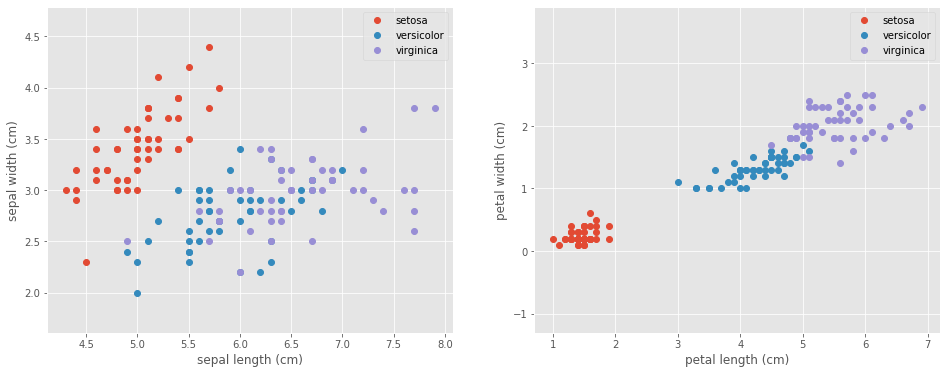

In [3]:
# Visualize the data sets
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 0], X_plot[:, 1], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.axis('equal')
plt.legend();

plt.subplot(1, 2, 2)
for target, target_name in enumerate(names):
    X_plot = X[y == target]
    plt.plot(X_plot[:, 2], X_plot[:, 3], linestyle='none', marker='o', label=target_name)
plt.xlabel(feature_names[2])
plt.ylabel(feature_names[3])
plt.axis('equal')
plt.legend();

# Setup the NN

In [6]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from tensorflow.keras import initializers

from keras.models import Sequential
from keras.layers import Dense

X_train, X_test, Y_train, Y_test = create_train_test(X[:,[2,3]],y)

print("X",X_train.shape,X_test.shape)
print("Y",Y_train.shape,Y_test.shape)
initializer = initializers.RandomUniform(minval=-2, maxval=2, seed=None)

# define baseline model
def baseline_model(name):
    # create model
    model = Sequential(name=name)
    model.add(Dense(3, input_dim=X_train.shape[1],activation='softmax',kernel_initializer=initializer))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

baseline_model('model_test').summary()

X (75, 2) (75, 2)
Y (75, 3) (75, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


## Setting up call backs

Callbacks is a Tensorflow API that provides an opportunity to tap a model for various "pulse" checks during training. You store the loss, image, weights, model at each epoch, batch, or set of batches. I will be setting up two callbacks:
1. A checkpoint callback
2. A tensorboard callback

In [7]:
from keras.callbacks import TensorBoard, ModelCheckpoint

# TensorBoard Callback
# cb_tb = TensorBoard('./data/logs/tb')

# history_dict = {}

In [25]:
Y_preds = []
for i in range(100):
    name = 'model.'+str(i)
    cb_mc = ModelCheckpoint(os.path.join('/Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights',
                                         name+'-'+'{epoch:02d}-{val_loss:.2f}.hdf5'),
                            verbose=1,save_weights_only=True,)
#     cb_mc = ModelCheckpoint(name+'.hdf5',verbose=0,save_weights_only=True,save_best_only=True,mode='min')
    model = baseline_model(name)
    history_callback = model.fit(X_train, Y_train,batch_size=5,epochs=150,verbose=0,validation_data=(X_test, Y_test),callbacks=[cb_mc])
    score = model.evaluate(X_test, Y_test, verbose=0)
    Y_pred = pd.DataFrame(model.predict(X_test),columns=['p1','p2','p3'])
    Y_pred['class'] = Y_pred.idxmax(axis=1)
    Y_pred['model']=name
    Y_preds.append(Y_pred)
#     print('Test loss {0}:'.format(name), score[0])
#     print('Test accuracy {0}:'.format(name), score[1])
Y_predsDF = pd.concat(Y_preds)
Y_predsDF.to_csv('/Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/petal_predictions.csv')


Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-01-0.82.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-02-0.81.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-03-0.79.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-04-0.78.hdf5

Epoch 00005: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-05-0.76.hdf5

Epoch 00006: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-06-0.75.hdf5

Epoch 00007: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-07-0.74.hdf5

Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-65-0.43.hdf5

Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-66-0.43.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-67-0.43.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-68-0.43.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-69-0.42.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-70-0.42.hdf5

Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-71-0.42.hdf5

Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-134-0.32.hdf5

Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-135-0.31.hdf5

Epoch 00136: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-136-0.31.hdf5

Epoch 00137: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-137-0.31.hdf5

Epoch 00138: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-138-0.31.hdf5

Epoch 00139: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-139-0.31.hdf5

Epoch 00140: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.0-140-0.31.hdf5

Epoch 00141: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-50-0.48.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-51-0.47.hdf5

Epoch 00052: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-52-0.47.hdf5

Epoch 00053: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-53-0.47.hdf5

Epoch 00054: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-54-0.47.hdf5

Epoch 00055: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-55-0.46.hdf5

Epoch 00056: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-56-0.46.hdf5

Epoch 00057: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00117: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-117-0.33.hdf5

Epoch 00118: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-118-0.33.hdf5

Epoch 00119: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-119-0.33.hdf5

Epoch 00120: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-120-0.33.hdf5

Epoch 00121: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-121-0.33.hdf5

Epoch 00122: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-122-0.33.hdf5

Epoch 00123: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.1-123-0.33.hdf5

Epoch 00124: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-32-0.40.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-33-0.40.hdf5

Epoch 00034: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-34-0.39.hdf5

Epoch 00035: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-35-0.39.hdf5

Epoch 00036: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-36-0.39.hdf5

Epoch 00037: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-37-0.38.hdf5

Epoch 00038: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-38-0.38.hdf5

Epoch 00039: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00096: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-96-0.27.hdf5

Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-97-0.27.hdf5

Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-98-0.27.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-99-0.27.hdf5

Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-100-0.27.hdf5

Epoch 00101: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-101-0.27.hdf5

Epoch 00102: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.2-102-0.26.hdf5

Epoch 00103: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/


Epoch 00009: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-09-0.43.hdf5

Epoch 00010: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-10-0.42.hdf5

Epoch 00011: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-11-0.42.hdf5

Epoch 00012: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-12-0.41.hdf5

Epoch 00013: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-13-0.40.hdf5

Epoch 00014: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-14-0.40.hdf5

Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-15-0.39.hdf5

Epoch 00016: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-72-0.27.hdf5

Epoch 00073: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-73-0.27.hdf5

Epoch 00074: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-74-0.27.hdf5

Epoch 00075: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-75-0.27.hdf5

Epoch 00076: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-76-0.27.hdf5

Epoch 00077: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-77-0.27.hdf5

Epoch 00078: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-78-0.26.hdf5

Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-135-0.22.hdf5

Epoch 00136: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-136-0.22.hdf5

Epoch 00137: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-137-0.22.hdf5

Epoch 00138: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-138-0.22.hdf5

Epoch 00139: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-139-0.22.hdf5

Epoch 00140: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-140-0.22.hdf5

Epoch 00141: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.3-141-0.21.hdf5

Epoch 00142: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-51-0.37.hdf5

Epoch 00052: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-52-0.37.hdf5

Epoch 00053: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-53-0.37.hdf5

Epoch 00054: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-54-0.37.hdf5

Epoch 00055: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-55-0.37.hdf5

Epoch 00056: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-56-0.36.hdf5

Epoch 00057: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-57-0.36.hdf5

Epoch 00058: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-114-0.27.hdf5

Epoch 00115: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-115-0.27.hdf5

Epoch 00116: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-116-0.27.hdf5

Epoch 00117: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-117-0.27.hdf5

Epoch 00118: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-118-0.27.hdf5

Epoch 00119: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-119-0.26.hdf5

Epoch 00120: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.4-120-0.26.hdf5

Epoch 00121: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-30-2.08.hdf5

Epoch 00031: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-31-2.04.hdf5

Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-32-2.01.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-33-1.97.hdf5

Epoch 00034: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-34-1.94.hdf5

Epoch 00035: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-35-1.90.hdf5

Epoch 00036: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-36-1.87.hdf5

Epoch 00037: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00093: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-93-0.80.hdf5

Epoch 00094: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-94-0.79.hdf5

Epoch 00095: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-95-0.79.hdf5

Epoch 00096: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-96-0.78.hdf5

Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-97-0.77.hdf5

Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-98-0.77.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.5-99-0.76.hdf5

Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00009: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-09-2.50.hdf5

Epoch 00010: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-10-2.46.hdf5

Epoch 00011: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-11-2.42.hdf5

Epoch 00012: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-12-2.38.hdf5

Epoch 00013: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-13-2.34.hdf5

Epoch 00014: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-14-2.30.hdf5

Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-15-2.26.hdf5

Epoch 00016: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00078: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-78-0.82.hdf5

Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-79-0.81.hdf5

Epoch 00080: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-80-0.80.hdf5

Epoch 00081: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-81-0.79.hdf5

Epoch 00082: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-82-0.78.hdf5

Epoch 00083: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-83-0.78.hdf5

Epoch 00084: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-84-0.77.hdf5

Epoch 00085: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-147-0.50.hdf5

Epoch 00148: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-148-0.50.hdf5

Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-149-0.50.hdf5

Epoch 00150: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.6-150-0.50.hdf5

Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-01-1.84.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-02-1.81.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-03-1.77.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data


Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-65-0.69.hdf5

Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-66-0.68.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-67-0.67.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-68-0.67.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-69-0.66.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-70-0.66.hdf5

Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-71-0.65.hdf5

Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-128-0.46.hdf5

Epoch 00129: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-129-0.46.hdf5

Epoch 00130: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-130-0.46.hdf5

Epoch 00131: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-131-0.46.hdf5

Epoch 00132: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-132-0.45.hdf5

Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-133-0.45.hdf5

Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.7-134-0.45.hdf5

Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-44-0.78.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-45-0.77.hdf5

Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-46-0.76.hdf5

Epoch 00047: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-47-0.75.hdf5

Epoch 00048: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-48-0.74.hdf5

Epoch 00049: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-49-0.73.hdf5

Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-50-0.72.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00107: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-107-0.46.hdf5

Epoch 00108: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-108-0.46.hdf5

Epoch 00109: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-109-0.46.hdf5

Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-110-0.46.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-111-0.45.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-112-0.45.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.8-113-0.45.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-23-0.47.hdf5

Epoch 00024: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-24-0.47.hdf5

Epoch 00025: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-25-0.46.hdf5

Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-26-0.46.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-27-0.46.hdf5

Epoch 00028: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-28-0.45.hdf5

Epoch 00029: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-29-0.45.hdf5

Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-86-0.32.hdf5

Epoch 00087: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-87-0.32.hdf5

Epoch 00088: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-88-0.32.hdf5

Epoch 00089: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-89-0.32.hdf5

Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-90-0.32.hdf5

Epoch 00091: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-91-0.31.hdf5

Epoch 00092: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-92-0.31.hdf5

Epoch 00093: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/log


Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-149-0.24.hdf5

Epoch 00150: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.9-150-0.24.hdf5

Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-01-0.74.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-02-0.73.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-03-0.71.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-04-0.70.hdf5

Epoch 00005: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-05-0.68.hdf5

Epoch 00006: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-65-0.37.hdf5

Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-66-0.37.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-67-0.37.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-68-0.37.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-69-0.36.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-70-0.36.hdf5

Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-71-0.36.hdf5

Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-128-0.27.hdf5

Epoch 00129: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-129-0.27.hdf5

Epoch 00130: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-130-0.27.hdf5

Epoch 00131: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-131-0.27.hdf5

Epoch 00132: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-132-0.27.hdf5

Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-133-0.27.hdf5

Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.10-134-0.27.hdf5

Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-44-1.22.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-45-1.20.hdf5

Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-46-1.18.hdf5

Epoch 00047: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-47-1.16.hdf5

Epoch 00048: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-48-1.15.hdf5

Epoch 00049: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-49-1.13.hdf5

Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-50-1.11.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00107: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-107-0.61.hdf5

Epoch 00108: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-108-0.60.hdf5

Epoch 00109: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-109-0.60.hdf5

Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-110-0.59.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-111-0.59.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-112-0.59.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.11-113-0.58.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-23-2.55.hdf5

Epoch 00024: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-24-2.51.hdf5

Epoch 00025: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-25-2.48.hdf5

Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-26-2.44.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-27-2.41.hdf5

Epoch 00028: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-28-2.38.hdf5

Epoch 00029: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-29-2.34.hdf5

Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-86-0.94.hdf5

Epoch 00087: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-87-0.93.hdf5

Epoch 00088: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-88-0.91.hdf5

Epoch 00089: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-89-0.90.hdf5

Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-90-0.88.hdf5

Epoch 00091: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-91-0.87.hdf5

Epoch 00092: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-92-0.86.hdf5

Epoch 00093: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-149-0.49.hdf5

Epoch 00150: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.12-150-0.48.hdf5

Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-01-5.57.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-02-5.52.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-03-5.47.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-04-5.42.hdf5

Epoch 00005: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-05-5.37.hdf5

Epoch 00006: saving model to /Users/meslami/Documents/GitRepos/deep_chaos


Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-65-2.68.hdf5

Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-66-2.64.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-67-2.61.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-68-2.57.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-69-2.54.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-70-2.50.hdf5

Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-71-2.47.hdf5

Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00127: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-127-1.06.hdf5

Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-128-1.04.hdf5

Epoch 00129: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-129-1.02.hdf5

Epoch 00130: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-130-1.01.hdf5

Epoch 00131: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-131-0.99.hdf5

Epoch 00132: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-132-0.98.hdf5

Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.13-133-0.96.hdf5

Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-44-0.84.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-45-0.83.hdf5

Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-46-0.82.hdf5

Epoch 00047: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-47-0.81.hdf5

Epoch 00048: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-48-0.80.hdf5

Epoch 00049: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-49-0.79.hdf5

Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-50-0.78.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00107: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-107-0.51.hdf5

Epoch 00108: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-108-0.51.hdf5

Epoch 00109: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-109-0.50.hdf5

Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-110-0.50.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-111-0.50.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-112-0.50.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.14-113-0.49.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-23-1.43.hdf5

Epoch 00024: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-24-1.41.hdf5

Epoch 00025: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-25-1.38.hdf5

Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-26-1.36.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-27-1.33.hdf5

Epoch 00028: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-28-1.31.hdf5

Epoch 00029: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-29-1.28.hdf5

Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-86-0.56.hdf5

Epoch 00087: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-87-0.55.hdf5

Epoch 00088: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-88-0.55.hdf5

Epoch 00089: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-89-0.54.hdf5

Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-90-0.54.hdf5

Epoch 00091: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-91-0.53.hdf5

Epoch 00092: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-92-0.53.hdf5

Epoch 00093: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-149-0.38.hdf5

Epoch 00150: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.15-150-0.38.hdf5

Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-01-0.62.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-02-0.62.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-03-0.61.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-04-0.60.hdf5

Epoch 00005: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-05-0.59.hdf5

Epoch 00006: saving model to /Users/meslami/Documents/GitRepos/deep_chaos


Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-65-0.37.hdf5

Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-66-0.37.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-67-0.37.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-68-0.37.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-69-0.36.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-70-0.36.hdf5

Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-71-0.36.hdf5

Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-128-0.27.hdf5

Epoch 00129: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-129-0.27.hdf5

Epoch 00130: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-130-0.27.hdf5

Epoch 00131: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-131-0.27.hdf5

Epoch 00132: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-132-0.27.hdf5

Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-133-0.26.hdf5

Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.16-134-0.26.hdf5

Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-44-0.77.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-45-0.76.hdf5

Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-46-0.76.hdf5

Epoch 00047: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-47-0.75.hdf5

Epoch 00048: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-48-0.74.hdf5

Epoch 00049: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-49-0.73.hdf5

Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-50-0.72.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00107: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-107-0.47.hdf5

Epoch 00108: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-108-0.47.hdf5

Epoch 00109: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-109-0.46.hdf5

Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-110-0.46.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-111-0.46.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-112-0.45.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.17-113-0.45.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-23-1.27.hdf5

Epoch 00024: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-24-1.24.hdf5

Epoch 00025: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-25-1.22.hdf5

Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-26-1.20.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-27-1.18.hdf5

Epoch 00028: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-28-1.15.hdf5

Epoch 00029: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-29-1.13.hdf5

Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-86-0.51.hdf5

Epoch 00087: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-87-0.51.hdf5

Epoch 00088: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-88-0.51.hdf5

Epoch 00089: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-89-0.50.hdf5

Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-90-0.50.hdf5

Epoch 00091: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-91-0.49.hdf5

Epoch 00092: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-92-0.49.hdf5

Epoch 00093: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-149-0.35.hdf5

Epoch 00150: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.18-150-0.35.hdf5

Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-01-2.89.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-02-2.85.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-03-2.80.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-04-2.76.hdf5

Epoch 00005: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-05-2.72.hdf5

Epoch 00006: saving model to /Users/meslami/Documents/GitRepos/deep_chaos


Epoch 00064: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-64-0.99.hdf5

Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-65-0.97.hdf5

Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-66-0.96.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-67-0.94.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-68-0.93.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-69-0.92.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-70-0.91.hdf5

Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00127: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-127-0.56.hdf5

Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-128-0.56.hdf5

Epoch 00129: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-129-0.55.hdf5

Epoch 00130: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-130-0.55.hdf5

Epoch 00131: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-131-0.55.hdf5

Epoch 00132: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-132-0.54.hdf5

Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.19-133-0.54.hdf5

Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-44-0.49.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-45-0.48.hdf5

Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-46-0.48.hdf5

Epoch 00047: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-47-0.48.hdf5

Epoch 00048: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-48-0.47.hdf5

Epoch 00049: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-49-0.47.hdf5

Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-50-0.47.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-113-0.35.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-114-0.35.hdf5

Epoch 00115: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-115-0.34.hdf5

Epoch 00116: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-116-0.34.hdf5

Epoch 00117: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-117-0.34.hdf5

Epoch 00118: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-118-0.34.hdf5

Epoch 00119: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.20-119-0.34.hdf5

Epoch 00120: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-30-1.59.hdf5

Epoch 00031: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-31-1.56.hdf5

Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-32-1.53.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-33-1.50.hdf5

Epoch 00034: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-34-1.47.hdf5

Epoch 00035: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-35-1.45.hdf5

Epoch 00036: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-36-1.42.hdf5

Epoch 00037: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00093: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-93-0.67.hdf5

Epoch 00094: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-94-0.67.hdf5

Epoch 00095: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-95-0.66.hdf5

Epoch 00096: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-96-0.66.hdf5

Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-97-0.65.hdf5

Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-98-0.65.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.21-99-0.64.hdf5

Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00009: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-09-0.54.hdf5

Epoch 00010: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-10-0.54.hdf5

Epoch 00011: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-11-0.53.hdf5

Epoch 00012: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-12-0.53.hdf5

Epoch 00013: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-13-0.52.hdf5

Epoch 00014: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-14-0.52.hdf5

Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-15-0.51.hdf5

Epoch 00016: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00078: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-78-0.35.hdf5

Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-79-0.34.hdf5

Epoch 00080: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-80-0.34.hdf5

Epoch 00081: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-81-0.34.hdf5

Epoch 00082: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-82-0.34.hdf5

Epoch 00083: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-83-0.34.hdf5

Epoch 00084: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-84-0.34.hdf5

Epoch 00085: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00141: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-141-0.27.hdf5

Epoch 00142: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-142-0.27.hdf5

Epoch 00143: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-143-0.27.hdf5

Epoch 00144: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-144-0.27.hdf5

Epoch 00145: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-145-0.26.hdf5

Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-146-0.26.hdf5

Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.22-147-0.26.hdf5

Epoch 00148: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00057: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-57-0.74.hdf5

Epoch 00058: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-58-0.73.hdf5

Epoch 00059: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-59-0.73.hdf5

Epoch 00060: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-60-0.72.hdf5

Epoch 00061: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-61-0.72.hdf5

Epoch 00062: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-62-0.71.hdf5

Epoch 00063: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-63-0.71.hdf5

Epoch 00064: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00119: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-119-0.51.hdf5

Epoch 00120: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-120-0.50.hdf5

Epoch 00121: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-121-0.50.hdf5

Epoch 00122: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-122-0.50.hdf5

Epoch 00123: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-123-0.50.hdf5

Epoch 00124: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-124-0.49.hdf5

Epoch 00125: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.23-125-0.49.hdf5

Epoch 00126: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00037: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-37-1.79.hdf5

Epoch 00038: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-38-1.76.hdf5

Epoch 00039: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-39-1.73.hdf5

Epoch 00040: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-40-1.70.hdf5

Epoch 00041: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-41-1.67.hdf5

Epoch 00042: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-42-1.64.hdf5

Epoch 00043: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-43-1.61.hdf5

Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-100-0.72.hdf5

Epoch 00101: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-101-0.71.hdf5

Epoch 00102: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-102-0.71.hdf5

Epoch 00103: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-103-0.70.hdf5

Epoch 00104: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-104-0.69.hdf5

Epoch 00105: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-105-0.69.hdf5

Epoch 00106: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.24-106-0.68.hdf5

Epoch 00107: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00016: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-16-2.76.hdf5

Epoch 00017: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-17-2.71.hdf5

Epoch 00018: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-18-2.67.hdf5

Epoch 00019: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-19-2.63.hdf5

Epoch 00020: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-20-2.59.hdf5

Epoch 00021: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-21-2.55.hdf5

Epoch 00022: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-22-2.51.hdf5

Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-79-1.01.hdf5

Epoch 00080: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-80-1.00.hdf5

Epoch 00081: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-81-0.98.hdf5

Epoch 00082: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-82-0.97.hdf5

Epoch 00083: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-83-0.96.hdf5

Epoch 00084: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-84-0.94.hdf5

Epoch 00085: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-85-0.93.hdf5

Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00142: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-142-0.57.hdf5

Epoch 00143: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-143-0.57.hdf5

Epoch 00144: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-144-0.56.hdf5

Epoch 00145: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-145-0.56.hdf5

Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-146-0.56.hdf5

Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-147-0.55.hdf5

Epoch 00148: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.25-148-0.55.hdf5

Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00058: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-58-0.60.hdf5

Epoch 00059: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-59-0.59.hdf5

Epoch 00060: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-60-0.59.hdf5

Epoch 00061: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-61-0.58.hdf5

Epoch 00062: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-62-0.58.hdf5

Epoch 00063: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-63-0.57.hdf5

Epoch 00064: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-64-0.57.hdf5

Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00121: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-121-0.41.hdf5

Epoch 00122: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-122-0.41.hdf5

Epoch 00123: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-123-0.40.hdf5

Epoch 00124: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-124-0.40.hdf5

Epoch 00125: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-125-0.40.hdf5

Epoch 00126: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-126-0.40.hdf5

Epoch 00127: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.26-127-0.40.hdf5

Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00037: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-37-1.32.hdf5

Epoch 00038: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-38-1.30.hdf5

Epoch 00039: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-39-1.28.hdf5

Epoch 00040: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-40-1.26.hdf5

Epoch 00041: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-41-1.24.hdf5

Epoch 00042: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-42-1.22.hdf5

Epoch 00043: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-43-1.20.hdf5

Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-100-0.66.hdf5

Epoch 00101: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-101-0.65.hdf5

Epoch 00102: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-102-0.65.hdf5

Epoch 00103: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-103-0.64.hdf5

Epoch 00104: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-104-0.64.hdf5

Epoch 00105: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-105-0.63.hdf5

Epoch 00106: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.27-106-0.63.hdf5

Epoch 00107: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00016: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-16-0.67.hdf5

Epoch 00017: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-17-0.66.hdf5

Epoch 00018: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-18-0.65.hdf5

Epoch 00019: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-19-0.64.hdf5

Epoch 00020: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-20-0.63.hdf5

Epoch 00021: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-21-0.62.hdf5

Epoch 00022: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-22-0.61.hdf5

Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-79-0.40.hdf5

Epoch 00080: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-80-0.39.hdf5

Epoch 00081: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-81-0.39.hdf5

Epoch 00082: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-82-0.39.hdf5

Epoch 00083: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-83-0.39.hdf5

Epoch 00084: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-84-0.38.hdf5

Epoch 00085: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-85-0.38.hdf5

Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00142: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-142-0.29.hdf5

Epoch 00143: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-143-0.29.hdf5

Epoch 00144: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-144-0.29.hdf5

Epoch 00145: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-145-0.29.hdf5

Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-146-0.29.hdf5

Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-147-0.29.hdf5

Epoch 00148: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.28-148-0.29.hdf5

Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00058: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-58-0.43.hdf5

Epoch 00059: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-59-0.43.hdf5

Epoch 00060: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-60-0.43.hdf5

Epoch 00061: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-61-0.42.hdf5

Epoch 00062: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-62-0.42.hdf5

Epoch 00063: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-63-0.42.hdf5

Epoch 00064: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-64-0.41.hdf5

Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00120: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-120-0.31.hdf5

Epoch 00121: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-121-0.31.hdf5

Epoch 00122: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-122-0.31.hdf5

Epoch 00123: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-123-0.31.hdf5

Epoch 00124: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-124-0.31.hdf5

Epoch 00125: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-125-0.31.hdf5

Epoch 00126: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.29-126-0.30.hdf5

Epoch 00127: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00034: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-34-1.13.hdf5

Epoch 00035: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-35-1.11.hdf5

Epoch 00036: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-36-1.10.hdf5

Epoch 00037: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-37-1.08.hdf5

Epoch 00038: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-38-1.07.hdf5

Epoch 00039: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-39-1.05.hdf5

Epoch 00040: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-40-1.03.hdf5

Epoch 00041: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00102: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-102-0.56.hdf5

Epoch 00103: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-103-0.56.hdf5

Epoch 00104: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-104-0.56.hdf5

Epoch 00105: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-105-0.55.hdf5

Epoch 00106: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-106-0.55.hdf5

Epoch 00107: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-107-0.55.hdf5

Epoch 00108: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.30-108-0.54.hdf5

Epoch 00109: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00016: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-16-3.53.hdf5

Epoch 00017: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-17-3.48.hdf5

Epoch 00018: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-18-3.44.hdf5

Epoch 00019: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-19-3.39.hdf5

Epoch 00020: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-20-3.35.hdf5

Epoch 00021: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-21-3.31.hdf5

Epoch 00022: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-22-3.26.hdf5

Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00084: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-84-1.27.hdf5

Epoch 00085: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-85-1.25.hdf5

Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-86-1.23.hdf5

Epoch 00087: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-87-1.22.hdf5

Epoch 00088: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-88-1.20.hdf5

Epoch 00089: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-89-1.18.hdf5

Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-90-1.16.hdf5

Epoch 00091: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-146-0.65.hdf5

Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-147-0.64.hdf5

Epoch 00148: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-148-0.64.hdf5

Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-149-0.63.hdf5

Epoch 00150: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.31-150-0.63.hdf5

Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-01-0.76.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-02-0.74.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_ch


Epoch 00064: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-64-0.41.hdf5

Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-65-0.40.hdf5

Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-66-0.40.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-67-0.40.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-68-0.40.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-69-0.40.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-70-0.39.hdf5

Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00131: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-131-0.29.hdf5

Epoch 00132: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-132-0.29.hdf5

Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-133-0.29.hdf5

Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-134-0.29.hdf5

Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-135-0.29.hdf5

Epoch 00136: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-136-0.29.hdf5

Epoch 00137: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.32-137-0.29.hdf5

Epoch 00138: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00048: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-48-1.13.hdf5

Epoch 00049: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-49-1.11.hdf5

Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-50-1.09.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-51-1.07.hdf5

Epoch 00052: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-52-1.06.hdf5

Epoch 00053: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-53-1.04.hdf5

Epoch 00054: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-54-1.02.hdf5

Epoch 00055: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-111-0.58.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-112-0.58.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-113-0.58.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-114-0.57.hdf5

Epoch 00115: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-115-0.57.hdf5

Epoch 00116: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-116-0.57.hdf5

Epoch 00117: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.33-117-0.56.hdf5

Epoch 00118: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00028: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-28-2.48.hdf5

Epoch 00029: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-29-2.44.hdf5

Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-30-2.41.hdf5

Epoch 00031: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-31-2.37.hdf5

Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-32-2.33.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-33-2.29.hdf5

Epoch 00034: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-34-2.25.hdf5

Epoch 00035: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00095: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-95-0.87.hdf5

Epoch 00096: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-96-0.86.hdf5

Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-97-0.85.hdf5

Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-98-0.84.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-99-0.83.hdf5

Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-100-0.82.hdf5

Epoch 00101: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.34-101-0.81.hdf5

Epoch 00102: saving model to /Users/meslami/Documents/GitRepos/deep_chaos


Epoch 00009: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-09-1.85.hdf5

Epoch 00010: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-10-1.81.hdf5

Epoch 00011: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-11-1.78.hdf5

Epoch 00012: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-12-1.75.hdf5

Epoch 00013: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-13-1.72.hdf5

Epoch 00014: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-14-1.68.hdf5

Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-15-1.65.hdf5

Epoch 00016: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00074: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-74-0.75.hdf5

Epoch 00075: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-75-0.75.hdf5

Epoch 00076: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-76-0.74.hdf5

Epoch 00077: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-77-0.73.hdf5

Epoch 00078: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-78-0.73.hdf5

Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-79-0.72.hdf5

Epoch 00080: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-80-0.72.hdf5

Epoch 00081: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00141: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-141-0.51.hdf5

Epoch 00142: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-142-0.51.hdf5

Epoch 00143: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-143-0.51.hdf5

Epoch 00144: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-144-0.50.hdf5

Epoch 00145: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-145-0.50.hdf5

Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-146-0.50.hdf5

Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.35-147-0.50.hdf5

Epoch 00148: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00056: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-56-0.37.hdf5

Epoch 00057: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-57-0.37.hdf5

Epoch 00058: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-58-0.37.hdf5

Epoch 00059: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-59-0.36.hdf5

Epoch 00060: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-60-0.36.hdf5

Epoch 00061: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-61-0.36.hdf5

Epoch 00062: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-62-0.36.hdf5

Epoch 00063: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00123: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-123-0.27.hdf5

Epoch 00124: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-124-0.27.hdf5

Epoch 00125: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-125-0.27.hdf5

Epoch 00126: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-126-0.26.hdf5

Epoch 00127: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-127-0.26.hdf5

Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-128-0.26.hdf5

Epoch 00129: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.36-129-0.26.hdf5

Epoch 00130: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00036: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-36-2.11.hdf5

Epoch 00037: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-37-2.07.hdf5

Epoch 00038: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-38-2.03.hdf5

Epoch 00039: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-39-2.00.hdf5

Epoch 00040: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-40-1.97.hdf5

Epoch 00041: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-41-1.93.hdf5

Epoch 00042: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-42-1.90.hdf5

Epoch 00043: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00105: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-105-0.76.hdf5

Epoch 00106: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-106-0.75.hdf5

Epoch 00107: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-107-0.74.hdf5

Epoch 00108: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-108-0.74.hdf5

Epoch 00109: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-109-0.73.hdf5

Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-110-0.72.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.37-111-0.72.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-23-0.90.hdf5

Epoch 00024: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-24-0.89.hdf5

Epoch 00025: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-25-0.87.hdf5

Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-26-0.86.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-27-0.84.hdf5

Epoch 00028: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-28-0.83.hdf5

Epoch 00029: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-29-0.82.hdf5

Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-90-0.47.hdf5

Epoch 00091: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-91-0.46.hdf5

Epoch 00092: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-92-0.46.hdf5

Epoch 00093: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-93-0.46.hdf5

Epoch 00094: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-94-0.46.hdf5

Epoch 00095: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-95-0.45.hdf5

Epoch 00096: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.38-96-0.45.hdf5

Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-02-0.75.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-03-0.73.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-04-0.71.hdf5

Epoch 00005: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-05-0.70.hdf5

Epoch 00006: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-06-0.68.hdf5

Epoch 00007: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-07-0.67.hdf5

Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-08-0.65.hdf5

Epoch 00009: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-71-0.34.hdf5

Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-72-0.34.hdf5

Epoch 00073: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-73-0.33.hdf5

Epoch 00074: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-74-0.33.hdf5

Epoch 00075: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-75-0.33.hdf5

Epoch 00076: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-76-0.33.hdf5

Epoch 00077: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-77-0.33.hdf5

Epoch 00078: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00139: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-139-0.25.hdf5

Epoch 00140: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-140-0.25.hdf5

Epoch 00141: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-141-0.25.hdf5

Epoch 00142: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-142-0.25.hdf5

Epoch 00143: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-143-0.25.hdf5

Epoch 00144: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-144-0.25.hdf5

Epoch 00145: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.39-145-0.25.hdf5

Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-51-0.52.hdf5

Epoch 00052: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-52-0.51.hdf5

Epoch 00053: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-53-0.51.hdf5

Epoch 00054: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-54-0.50.hdf5

Epoch 00055: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-55-0.49.hdf5

Epoch 00056: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-56-0.49.hdf5

Epoch 00057: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-57-0.48.hdf5

Epoch 00058: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00118: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-118-0.31.hdf5

Epoch 00119: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-119-0.31.hdf5

Epoch 00120: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-120-0.31.hdf5

Epoch 00121: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-121-0.30.hdf5

Epoch 00122: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-122-0.30.hdf5

Epoch 00123: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-123-0.30.hdf5

Epoch 00124: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.40-124-0.30.hdf5

Epoch 00125: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-30-2.13.hdf5

Epoch 00031: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-31-2.10.hdf5

Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-32-2.06.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-33-2.03.hdf5

Epoch 00034: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-34-1.99.hdf5

Epoch 00035: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-35-1.96.hdf5

Epoch 00036: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-36-1.92.hdf5

Epoch 00037: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-98-0.77.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-99-0.76.hdf5

Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-100-0.75.hdf5

Epoch 00101: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-101-0.75.hdf5

Epoch 00102: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-102-0.74.hdf5

Epoch 00103: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-103-0.73.hdf5

Epoch 00104: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.41-104-0.73.hdf5

Epoch 00105: saving model to /Users/meslami/Documents/GitRepos/deep_ch


Epoch 00016: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-16-2.12.hdf5

Epoch 00017: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-17-2.08.hdf5

Epoch 00018: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-18-2.05.hdf5

Epoch 00019: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-19-2.01.hdf5

Epoch 00020: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-20-1.98.hdf5

Epoch 00021: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-21-1.94.hdf5

Epoch 00022: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-22-1.91.hdf5

Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-79-0.74.hdf5

Epoch 00080: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-80-0.74.hdf5

Epoch 00081: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-81-0.73.hdf5

Epoch 00082: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-82-0.72.hdf5

Epoch 00083: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-83-0.71.hdf5

Epoch 00084: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-84-0.70.hdf5

Epoch 00085: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-85-0.70.hdf5

Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00145: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-145-0.46.hdf5

Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-146-0.46.hdf5

Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-147-0.46.hdf5

Epoch 00148: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-148-0.45.hdf5

Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-149-0.45.hdf5

Epoch 00150: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.42-150-0.45.hdf5

Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-01-0.87.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_c


Epoch 00063: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-63-0.43.hdf5

Epoch 00064: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-64-0.43.hdf5

Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-65-0.43.hdf5

Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-66-0.42.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-67-0.42.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-68-0.42.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-69-0.42.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00125: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-125-0.32.hdf5

Epoch 00126: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-126-0.31.hdf5

Epoch 00127: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-127-0.31.hdf5

Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-128-0.31.hdf5

Epoch 00129: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-129-0.31.hdf5

Epoch 00130: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-130-0.31.hdf5

Epoch 00131: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.43-131-0.31.hdf5

Epoch 00132: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00043: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-43-0.55.hdf5

Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-44-0.54.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-45-0.54.hdf5

Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-46-0.54.hdf5

Epoch 00047: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-47-0.53.hdf5

Epoch 00048: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-48-0.53.hdf5

Epoch 00049: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-49-0.52.hdf5

Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-110-0.39.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-111-0.38.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-112-0.38.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-113-0.38.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-114-0.38.hdf5

Epoch 00115: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-115-0.38.hdf5

Epoch 00116: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.44-116-0.38.hdf5

Epoch 00117: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00028: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-28-1.20.hdf5

Epoch 00029: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-29-1.17.hdf5

Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-30-1.15.hdf5

Epoch 00031: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-31-1.13.hdf5

Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-32-1.11.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-33-1.09.hdf5

Epoch 00034: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-34-1.07.hdf5

Epoch 00035: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-97-0.49.hdf5

Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-98-0.49.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-99-0.48.hdf5

Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-100-0.48.hdf5

Epoch 00101: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-101-0.48.hdf5

Epoch 00102: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-102-0.47.hdf5

Epoch 00103: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.45-103-0.47.hdf5

Epoch 00104: saving model to /Users/meslami/Documents/GitRepos/deep_cha


Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-15-1.24.hdf5

Epoch 00016: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-16-1.22.hdf5

Epoch 00017: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-17-1.19.hdf5

Epoch 00018: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-18-1.17.hdf5

Epoch 00019: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-19-1.15.hdf5

Epoch 00020: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-20-1.13.hdf5

Epoch 00021: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-21-1.11.hdf5

Epoch 00022: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00083: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-83-0.56.hdf5

Epoch 00084: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-84-0.56.hdf5

Epoch 00085: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-85-0.56.hdf5

Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-86-0.55.hdf5

Epoch 00087: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-87-0.55.hdf5

Epoch 00088: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-88-0.55.hdf5

Epoch 00089: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-89-0.54.hdf5

Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-147-0.41.hdf5

Epoch 00148: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-148-0.41.hdf5

Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-149-0.41.hdf5

Epoch 00150: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.46-150-0.40.hdf5

Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-01-0.63.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-02-0.62.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-03-0.61.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_cha


Epoch 00061: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-61-0.34.hdf5

Epoch 00062: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-62-0.34.hdf5

Epoch 00063: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-63-0.33.hdf5

Epoch 00064: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-64-0.33.hdf5

Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-65-0.33.hdf5

Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-66-0.33.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-67-0.33.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00126: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-126-0.25.hdf5

Epoch 00127: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-127-0.25.hdf5

Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-128-0.25.hdf5

Epoch 00129: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-129-0.25.hdf5

Epoch 00130: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-130-0.25.hdf5

Epoch 00131: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-131-0.25.hdf5

Epoch 00132: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.47-132-0.24.hdf5

Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00039: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-39-1.31.hdf5

Epoch 00040: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-40-1.29.hdf5

Epoch 00041: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-41-1.26.hdf5

Epoch 00042: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-42-1.24.hdf5

Epoch 00043: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-43-1.22.hdf5

Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-44-1.20.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-45-1.18.hdf5

Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00106: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-106-0.61.hdf5

Epoch 00107: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-107-0.61.hdf5

Epoch 00108: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-108-0.61.hdf5

Epoch 00109: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-109-0.60.hdf5

Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-110-0.60.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-111-0.59.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.48-112-0.59.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00020: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-20-0.77.hdf5

Epoch 00021: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-21-0.76.hdf5

Epoch 00022: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-22-0.75.hdf5

Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-23-0.74.hdf5

Epoch 00024: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-24-0.72.hdf5

Epoch 00025: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-25-0.71.hdf5

Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-26-0.70.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00084: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-84-0.43.hdf5

Epoch 00085: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-85-0.43.hdf5

Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-86-0.42.hdf5

Epoch 00087: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-87-0.42.hdf5

Epoch 00088: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-88-0.42.hdf5

Epoch 00089: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-89-0.42.hdf5

Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-90-0.41.hdf5

Epoch 00091: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-147-0.33.hdf5

Epoch 00148: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-148-0.33.hdf5

Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-149-0.33.hdf5

Epoch 00150: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.49-150-0.32.hdf5

Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-01-1.85.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-02-1.81.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-03-1.78.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_cha


Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-65-0.73.hdf5

Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-66-0.73.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-67-0.72.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-68-0.71.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-69-0.71.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-70-0.70.hdf5

Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-71-0.70.hdf5

Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-128-0.49.hdf5

Epoch 00129: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-129-0.49.hdf5

Epoch 00130: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-130-0.49.hdf5

Epoch 00131: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-131-0.49.hdf5

Epoch 00132: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-132-0.48.hdf5

Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-133-0.48.hdf5

Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.50-134-0.48.hdf5

Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00040: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-40-0.38.hdf5

Epoch 00041: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-41-0.38.hdf5

Epoch 00042: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-42-0.38.hdf5

Epoch 00043: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-43-0.38.hdf5

Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-44-0.38.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-45-0.37.hdf5

Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-46-0.37.hdf5

Epoch 00047: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00107: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-107-0.28.hdf5

Epoch 00108: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-108-0.28.hdf5

Epoch 00109: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-109-0.28.hdf5

Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-110-0.28.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-111-0.28.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-112-0.27.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.51-113-0.27.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00021: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-21-0.94.hdf5

Epoch 00022: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-22-0.92.hdf5

Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-23-0.91.hdf5

Epoch 00024: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-24-0.89.hdf5

Epoch 00025: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-25-0.87.hdf5

Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-26-0.86.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-27-0.84.hdf5

Epoch 00028: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00085: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-85-0.47.hdf5

Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-86-0.46.hdf5

Epoch 00087: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-87-0.46.hdf5

Epoch 00088: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-88-0.46.hdf5

Epoch 00089: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-89-0.46.hdf5

Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-90-0.45.hdf5

Epoch 00091: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.52-91-0.45.hdf5

Epoch 00092: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-01-1.84.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-02-1.80.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-03-1.77.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-04-1.73.hdf5

Epoch 00005: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-05-1.70.hdf5

Epoch 00006: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-06-1.66.hdf5

Epoch 00007: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-07-1.63.hdf5

Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00064: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-64-0.69.hdf5

Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-65-0.68.hdf5

Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-66-0.68.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-67-0.67.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-68-0.66.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-69-0.66.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-70-0.65.hdf5

Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00131: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-131-0.46.hdf5

Epoch 00132: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-132-0.46.hdf5

Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-133-0.45.hdf5

Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-134-0.45.hdf5

Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-135-0.45.hdf5

Epoch 00136: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-136-0.45.hdf5

Epoch 00137: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.53-137-0.45.hdf5

Epoch 00138: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-44-1.21.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-45-1.18.hdf5

Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-46-1.17.hdf5

Epoch 00047: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-47-1.15.hdf5

Epoch 00048: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-48-1.13.hdf5

Epoch 00049: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-49-1.11.hdf5

Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-50-1.09.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-110-0.59.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-111-0.59.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-112-0.59.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-113-0.58.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-114-0.58.hdf5

Epoch 00115: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-115-0.58.hdf5

Epoch 00116: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.54-116-0.57.hdf5

Epoch 00117: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00028: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-28-0.72.hdf5

Epoch 00029: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-29-0.70.hdf5

Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-30-0.69.hdf5

Epoch 00031: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-31-0.68.hdf5

Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-32-0.67.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-33-0.66.hdf5

Epoch 00034: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-34-0.65.hdf5

Epoch 00035: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00094: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-94-0.39.hdf5

Epoch 00095: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-95-0.39.hdf5

Epoch 00096: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-96-0.39.hdf5

Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-97-0.38.hdf5

Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-98-0.38.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-99-0.38.hdf5

Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.55-100-0.38.hdf5

Epoch 00101: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/


Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-08-1.78.hdf5

Epoch 00009: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-09-1.74.hdf5

Epoch 00010: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-10-1.71.hdf5

Epoch 00011: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-11-1.67.hdf5

Epoch 00012: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-12-1.64.hdf5

Epoch 00013: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-13-1.61.hdf5

Epoch 00014: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-14-1.58.hdf5

Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00074: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-74-0.65.hdf5

Epoch 00075: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-75-0.65.hdf5

Epoch 00076: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-76-0.64.hdf5

Epoch 00077: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-77-0.64.hdf5

Epoch 00078: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-78-0.63.hdf5

Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-79-0.63.hdf5

Epoch 00080: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-80-0.62.hdf5

Epoch 00081: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00140: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-140-0.45.hdf5

Epoch 00141: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-141-0.45.hdf5

Epoch 00142: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-142-0.45.hdf5

Epoch 00143: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-143-0.44.hdf5

Epoch 00144: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-144-0.44.hdf5

Epoch 00145: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-145-0.44.hdf5

Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.56-146-0.44.hdf5

Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00056: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-56-0.45.hdf5

Epoch 00057: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-57-0.45.hdf5

Epoch 00058: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-58-0.44.hdf5

Epoch 00059: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-59-0.44.hdf5

Epoch 00060: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-60-0.44.hdf5

Epoch 00061: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-61-0.43.hdf5

Epoch 00062: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-62-0.43.hdf5

Epoch 00063: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00122: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-122-0.32.hdf5

Epoch 00123: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-123-0.32.hdf5

Epoch 00124: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-124-0.31.hdf5

Epoch 00125: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-125-0.31.hdf5

Epoch 00126: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-126-0.31.hdf5

Epoch 00127: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-127-0.31.hdf5

Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.57-128-0.31.hdf5

Epoch 00129: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00038: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-38-0.41.hdf5

Epoch 00039: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-39-0.41.hdf5

Epoch 00040: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-40-0.41.hdf5

Epoch 00041: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-41-0.41.hdf5

Epoch 00042: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-42-0.40.hdf5

Epoch 00043: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-43-0.40.hdf5

Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-44-0.40.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00105: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-105-0.29.hdf5

Epoch 00106: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-106-0.29.hdf5

Epoch 00107: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-107-0.28.hdf5

Epoch 00108: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-108-0.28.hdf5

Epoch 00109: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-109-0.28.hdf5

Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-110-0.28.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.58-111-0.28.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00020: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-20-0.88.hdf5

Epoch 00021: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-21-0.87.hdf5

Epoch 00022: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-22-0.85.hdf5

Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-23-0.84.hdf5

Epoch 00024: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-24-0.82.hdf5

Epoch 00025: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-25-0.81.hdf5

Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-26-0.80.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-86-0.46.hdf5

Epoch 00087: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-87-0.45.hdf5

Epoch 00088: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-88-0.45.hdf5

Epoch 00089: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-89-0.45.hdf5

Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-90-0.45.hdf5

Epoch 00091: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-91-0.44.hdf5

Epoch 00092: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.59-92-0.44.hdf5

Epoch 00093: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-01-1.32.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-02-1.29.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-03-1.27.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-04-1.24.hdf5

Epoch 00005: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-05-1.21.hdf5

Epoch 00006: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-06-1.19.hdf5

Epoch 00007: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-07-1.16.hdf5

Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-68-0.55.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-69-0.54.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-70-0.54.hdf5

Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-71-0.54.hdf5

Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-72-0.53.hdf5

Epoch 00073: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-73-0.53.hdf5

Epoch 00074: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-74-0.53.hdf5

Epoch 00075: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-134-0.39.hdf5

Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-135-0.39.hdf5

Epoch 00136: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-136-0.39.hdf5

Epoch 00137: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-137-0.39.hdf5

Epoch 00138: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-138-0.39.hdf5

Epoch 00139: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-139-0.38.hdf5

Epoch 00140: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.60-140-0.38.hdf5

Epoch 00141: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-50-2.52.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-51-2.49.hdf5

Epoch 00052: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-52-2.45.hdf5

Epoch 00053: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-53-2.41.hdf5

Epoch 00054: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-54-2.38.hdf5

Epoch 00055: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-55-2.34.hdf5

Epoch 00056: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-56-2.31.hdf5

Epoch 00057: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00116: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-116-0.89.hdf5

Epoch 00117: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-117-0.88.hdf5

Epoch 00118: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-118-0.87.hdf5

Epoch 00119: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-119-0.86.hdf5

Epoch 00120: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-120-0.85.hdf5

Epoch 00121: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-121-0.84.hdf5

Epoch 00122: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.61-122-0.83.hdf5

Epoch 00123: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-32-0.69.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-33-0.69.hdf5

Epoch 00034: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-34-0.68.hdf5

Epoch 00035: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-35-0.67.hdf5

Epoch 00036: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-36-0.66.hdf5

Epoch 00037: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-37-0.65.hdf5

Epoch 00038: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-38-0.65.hdf5

Epoch 00039: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-98-0.41.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-99-0.41.hdf5

Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-100-0.41.hdf5

Epoch 00101: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-101-0.41.hdf5

Epoch 00102: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-102-0.40.hdf5

Epoch 00103: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-103-0.40.hdf5

Epoch 00104: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.62-104-0.40.hdf5

Epoch 00105: saving model to /Users/meslami/Documents/GitRepos/deep_ch


Epoch 00014: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-14-0.94.hdf5

Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-15-0.92.hdf5

Epoch 00016: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-16-0.91.hdf5

Epoch 00017: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-17-0.89.hdf5

Epoch 00018: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-18-0.88.hdf5

Epoch 00019: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-19-0.86.hdf5

Epoch 00020: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-20-0.85.hdf5

Epoch 00021: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00080: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-80-0.48.hdf5

Epoch 00081: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-81-0.48.hdf5

Epoch 00082: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-82-0.47.hdf5

Epoch 00083: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-83-0.47.hdf5

Epoch 00084: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-84-0.47.hdf5

Epoch 00085: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-85-0.47.hdf5

Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-86-0.46.hdf5

Epoch 00087: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-146-0.35.hdf5

Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-147-0.35.hdf5

Epoch 00148: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-148-0.35.hdf5

Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-149-0.35.hdf5

Epoch 00150: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.63-150-0.34.hdf5

Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-01-2.20.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-02-2.16.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_ch


Epoch 00062: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-62-0.87.hdf5

Epoch 00063: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-63-0.86.hdf5

Epoch 00064: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-64-0.85.hdf5

Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-65-0.84.hdf5

Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-66-0.83.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-67-0.82.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-68-0.81.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-128-0.52.hdf5

Epoch 00129: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-129-0.51.hdf5

Epoch 00130: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-130-0.51.hdf5

Epoch 00131: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-131-0.51.hdf5

Epoch 00132: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-132-0.51.hdf5

Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-133-0.50.hdf5

Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.64-134-0.50.hdf5

Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-44-0.53.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-45-0.53.hdf5

Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-46-0.52.hdf5

Epoch 00047: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-47-0.51.hdf5

Epoch 00048: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-48-0.51.hdf5

Epoch 00049: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-49-0.50.hdf5

Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-50-0.50.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-110-0.33.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-111-0.33.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-112-0.33.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-113-0.33.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-114-0.33.hdf5

Epoch 00115: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-115-0.32.hdf5

Epoch 00116: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.65-116-0.32.hdf5

Epoch 00117: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-26-1.53.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-27-1.50.hdf5

Epoch 00028: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-28-1.47.hdf5

Epoch 00029: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-29-1.45.hdf5

Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-30-1.43.hdf5

Epoch 00031: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-31-1.40.hdf5

Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-32-1.38.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00092: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-92-0.68.hdf5

Epoch 00093: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-93-0.67.hdf5

Epoch 00094: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-94-0.67.hdf5

Epoch 00095: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-95-0.66.hdf5

Epoch 00096: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-96-0.66.hdf5

Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-97-0.65.hdf5

Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.66-98-0.65.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-08-0.77.hdf5

Epoch 00009: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-09-0.76.hdf5

Epoch 00010: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-10-0.74.hdf5

Epoch 00011: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-11-0.73.hdf5

Epoch 00012: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-12-0.72.hdf5

Epoch 00013: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-13-0.71.hdf5

Epoch 00014: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-14-0.69.hdf5

Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00074: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-74-0.41.hdf5

Epoch 00075: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-75-0.41.hdf5

Epoch 00076: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-76-0.40.hdf5

Epoch 00077: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-77-0.40.hdf5

Epoch 00078: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-78-0.40.hdf5

Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-79-0.40.hdf5

Epoch 00080: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-80-0.40.hdf5

Epoch 00081: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00140: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-140-0.30.hdf5

Epoch 00141: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-141-0.30.hdf5

Epoch 00142: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-142-0.30.hdf5

Epoch 00143: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-143-0.30.hdf5

Epoch 00144: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-144-0.30.hdf5

Epoch 00145: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-145-0.30.hdf5

Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.67-146-0.30.hdf5

Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00056: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-56-2.12.hdf5

Epoch 00057: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-57-2.09.hdf5

Epoch 00058: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-58-2.06.hdf5

Epoch 00059: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-59-2.03.hdf5

Epoch 00060: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-60-2.00.hdf5

Epoch 00061: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-61-1.97.hdf5

Epoch 00062: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-62-1.94.hdf5

Epoch 00063: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00121: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-121-0.79.hdf5

Epoch 00122: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-122-0.78.hdf5

Epoch 00123: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-123-0.77.hdf5

Epoch 00124: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-124-0.76.hdf5

Epoch 00125: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-125-0.75.hdf5

Epoch 00126: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-126-0.75.hdf5

Epoch 00127: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.68-127-0.74.hdf5

Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00038: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-38-0.96.hdf5

Epoch 00039: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-39-0.95.hdf5

Epoch 00040: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-40-0.93.hdf5

Epoch 00041: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-41-0.92.hdf5

Epoch 00042: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-42-0.91.hdf5

Epoch 00043: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-43-0.89.hdf5

Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-44-0.88.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00104: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-104-0.53.hdf5

Epoch 00105: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-105-0.53.hdf5

Epoch 00106: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-106-0.52.hdf5

Epoch 00107: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-107-0.52.hdf5

Epoch 00108: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-108-0.52.hdf5

Epoch 00109: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-109-0.52.hdf5

Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.69-110-0.51.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00020: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-20-0.52.hdf5

Epoch 00021: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-21-0.51.hdf5

Epoch 00022: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-22-0.51.hdf5

Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-23-0.51.hdf5

Epoch 00024: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-24-0.50.hdf5

Epoch 00025: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-25-0.50.hdf5

Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-26-0.49.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-86-0.34.hdf5

Epoch 00087: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-87-0.34.hdf5

Epoch 00088: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-88-0.34.hdf5

Epoch 00089: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-89-0.34.hdf5

Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-90-0.33.hdf5

Epoch 00091: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-91-0.33.hdf5

Epoch 00092: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.70-92-0.33.hdf5

Epoch 00093: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-01-2.28.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-02-2.24.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-03-2.20.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-04-2.16.hdf5

Epoch 00005: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-05-2.12.hdf5

Epoch 00006: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-06-2.09.hdf5

Epoch 00007: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-07-2.05.hdf5

Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-68-0.72.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-69-0.71.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-70-0.70.hdf5

Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-71-0.69.hdf5

Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-72-0.69.hdf5

Epoch 00073: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-73-0.68.hdf5

Epoch 00074: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-74-0.67.hdf5

Epoch 00075: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00130: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-130-0.45.hdf5

Epoch 00131: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-131-0.45.hdf5

Epoch 00132: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-132-0.45.hdf5

Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-133-0.44.hdf5

Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-134-0.44.hdf5

Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-135-0.44.hdf5

Epoch 00136: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.71-136-0.44.hdf5

Epoch 00137: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-44-1.10.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-45-1.08.hdf5

Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-46-1.06.hdf5

Epoch 00047: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-47-1.04.hdf5

Epoch 00048: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-48-1.03.hdf5

Epoch 00049: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-49-1.01.hdf5

Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-50-1.00.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-110-0.56.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-111-0.56.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-112-0.56.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-113-0.56.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-114-0.55.hdf5

Epoch 00115: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-115-0.55.hdf5

Epoch 00116: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.72-116-0.55.hdf5

Epoch 00117: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-26-1.14.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-27-1.12.hdf5

Epoch 00028: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-28-1.10.hdf5

Epoch 00029: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-29-1.08.hdf5

Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-30-1.06.hdf5

Epoch 00031: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-31-1.04.hdf5

Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-32-1.03.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-90-0.57.hdf5

Epoch 00091: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-91-0.56.hdf5

Epoch 00092: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-92-0.56.hdf5

Epoch 00093: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-93-0.56.hdf5

Epoch 00094: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-94-0.55.hdf5

Epoch 00095: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-95-0.55.hdf5

Epoch 00096: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.73-96-0.55.hdf5

Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-02-0.93.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-03-0.91.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-04-0.88.hdf5

Epoch 00005: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-05-0.86.hdf5

Epoch 00006: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-06-0.85.hdf5

Epoch 00007: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-07-0.83.hdf5

Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-08-0.81.hdf5

Epoch 00009: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-66-0.43.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-67-0.43.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-68-0.43.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-69-0.43.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-70-0.42.hdf5

Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-71-0.42.hdf5

Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-72-0.42.hdf5

Epoch 00073: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-133-0.32.hdf5

Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-134-0.31.hdf5

Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-135-0.31.hdf5

Epoch 00136: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-136-0.31.hdf5

Epoch 00137: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-137-0.31.hdf5

Epoch 00138: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-138-0.31.hdf5

Epoch 00139: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.74-139-0.31.hdf5

Epoch 00140: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-46-1.65.hdf5

Epoch 00047: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-47-1.62.hdf5

Epoch 00048: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-48-1.59.hdf5

Epoch 00049: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-49-1.57.hdf5

Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-50-1.54.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-51-1.51.hdf5

Epoch 00052: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-52-1.48.hdf5

Epoch 00053: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-110-0.65.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-111-0.64.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-112-0.64.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-113-0.63.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-114-0.63.hdf5

Epoch 00115: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-115-0.62.hdf5

Epoch 00116: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.75-116-0.62.hdf5

Epoch 00117: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-26-1.59.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-27-1.56.hdf5

Epoch 00028: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-28-1.54.hdf5

Epoch 00029: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-29-1.51.hdf5

Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-30-1.49.hdf5

Epoch 00031: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-31-1.46.hdf5

Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-32-1.44.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00092: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-92-0.66.hdf5

Epoch 00093: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-93-0.66.hdf5

Epoch 00094: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-94-0.65.hdf5

Epoch 00095: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-95-0.65.hdf5

Epoch 00096: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-96-0.64.hdf5

Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-97-0.64.hdf5

Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.76-98-0.63.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-08-0.84.hdf5

Epoch 00009: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-09-0.83.hdf5

Epoch 00010: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-10-0.82.hdf5

Epoch 00011: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-11-0.80.hdf5

Epoch 00012: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-12-0.79.hdf5

Epoch 00013: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-13-0.78.hdf5

Epoch 00014: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-14-0.77.hdf5

Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00073: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-73-0.47.hdf5

Epoch 00074: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-74-0.47.hdf5

Epoch 00075: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-75-0.46.hdf5

Epoch 00076: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-76-0.46.hdf5

Epoch 00077: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-77-0.46.hdf5

Epoch 00078: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-78-0.46.hdf5

Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-79-0.45.hdf5

Epoch 00080: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00139: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-139-0.34.hdf5

Epoch 00140: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-140-0.34.hdf5

Epoch 00141: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-141-0.34.hdf5

Epoch 00142: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-142-0.33.hdf5

Epoch 00143: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-143-0.33.hdf5

Epoch 00144: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-144-0.33.hdf5

Epoch 00145: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.77-145-0.33.hdf5

Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00056: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-56-0.45.hdf5

Epoch 00057: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-57-0.44.hdf5

Epoch 00058: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-58-0.44.hdf5

Epoch 00059: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-59-0.44.hdf5

Epoch 00060: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-60-0.44.hdf5

Epoch 00061: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-61-0.43.hdf5

Epoch 00062: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-62-0.43.hdf5

Epoch 00063: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00121: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-121-0.31.hdf5

Epoch 00122: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-122-0.31.hdf5

Epoch 00123: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-123-0.31.hdf5

Epoch 00124: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-124-0.31.hdf5

Epoch 00125: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-125-0.31.hdf5

Epoch 00126: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-126-0.31.hdf5

Epoch 00127: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.78-127-0.30.hdf5

Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00038: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-38-0.49.hdf5

Epoch 00039: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-39-0.49.hdf5

Epoch 00040: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-40-0.48.hdf5

Epoch 00041: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-41-0.48.hdf5

Epoch 00042: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-42-0.48.hdf5

Epoch 00043: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-43-0.47.hdf5

Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-44-0.47.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00103: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-103-0.34.hdf5

Epoch 00104: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-104-0.34.hdf5

Epoch 00105: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-105-0.34.hdf5

Epoch 00106: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-106-0.33.hdf5

Epoch 00107: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-107-0.33.hdf5

Epoch 00108: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-108-0.33.hdf5

Epoch 00109: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.79-109-0.33.hdf5

Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00020: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-20-0.47.hdf5

Epoch 00021: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-21-0.47.hdf5

Epoch 00022: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-22-0.47.hdf5

Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-23-0.46.hdf5

Epoch 00024: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-24-0.46.hdf5

Epoch 00025: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-25-0.46.hdf5

Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-26-0.45.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00085: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-85-0.32.hdf5

Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-86-0.32.hdf5

Epoch 00087: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-87-0.32.hdf5

Epoch 00088: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-88-0.31.hdf5

Epoch 00089: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-89-0.31.hdf5

Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-90-0.31.hdf5

Epoch 00091: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.80-91-0.31.hdf5

Epoch 00092: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-01-0.59.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-02-0.58.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-03-0.57.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-04-0.57.hdf5

Epoch 00005: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-05-0.56.hdf5

Epoch 00006: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-06-0.55.hdf5

Epoch 00007: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-07-0.54.hdf5

Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-68-0.35.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-69-0.35.hdf5

Epoch 00070: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-70-0.35.hdf5

Epoch 00071: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-71-0.35.hdf5

Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-72-0.34.hdf5

Epoch 00073: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-73-0.34.hdf5

Epoch 00074: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-74-0.34.hdf5

Epoch 00075: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-133-0.26.hdf5

Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-134-0.26.hdf5

Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-135-0.26.hdf5

Epoch 00136: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-136-0.26.hdf5

Epoch 00137: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-137-0.26.hdf5

Epoch 00138: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-138-0.25.hdf5

Epoch 00139: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.81-139-0.25.hdf5

Epoch 00140: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-45-1.03.hdf5

Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-46-1.02.hdf5

Epoch 00047: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-47-1.00.hdf5

Epoch 00048: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-48-0.99.hdf5

Epoch 00049: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-49-0.97.hdf5

Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-50-0.96.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-51-0.95.hdf5

Epoch 00052: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00108: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-108-0.57.hdf5

Epoch 00109: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-109-0.56.hdf5

Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-110-0.56.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-111-0.56.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-112-0.55.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-113-0.55.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.82-114-0.55.hdf5

Epoch 00115: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00020: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-20-0.57.hdf5

Epoch 00021: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-21-0.57.hdf5

Epoch 00022: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-22-0.56.hdf5

Epoch 00023: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-23-0.56.hdf5

Epoch 00024: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-24-0.55.hdf5

Epoch 00025: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-25-0.55.hdf5

Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-26-0.54.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00083: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-83-0.38.hdf5

Epoch 00084: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-84-0.37.hdf5

Epoch 00085: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-85-0.37.hdf5

Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-86-0.37.hdf5

Epoch 00087: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-87-0.37.hdf5

Epoch 00088: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-88-0.37.hdf5

Epoch 00089: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-89-0.36.hdf5

Epoch 00090: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-147-0.29.hdf5

Epoch 00148: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-148-0.28.hdf5

Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-149-0.28.hdf5

Epoch 00150: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.83-150-0.28.hdf5

Epoch 00001: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-01-4.23.hdf5

Epoch 00002: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-02-4.19.hdf5

Epoch 00003: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-03-4.14.hdf5

Epoch 00004: saving model to /Users/meslami/Documents/GitRepos/deep_cha


Epoch 00062: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-62-1.74.hdf5

Epoch 00063: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-63-1.71.hdf5

Epoch 00064: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-64-1.68.hdf5

Epoch 00065: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-65-1.65.hdf5

Epoch 00066: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-66-1.63.hdf5

Epoch 00067: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-67-1.60.hdf5

Epoch 00068: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-68-1.57.hdf5

Epoch 00069: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00128: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-128-0.70.hdf5

Epoch 00129: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-129-0.69.hdf5

Epoch 00130: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-130-0.69.hdf5

Epoch 00131: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-131-0.68.hdf5

Epoch 00132: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-132-0.68.hdf5

Epoch 00133: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-133-0.67.hdf5

Epoch 00134: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.84-134-0.67.hdf5

Epoch 00135: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00044: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-44-2.37.hdf5

Epoch 00045: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-45-2.34.hdf5

Epoch 00046: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-46-2.31.hdf5

Epoch 00047: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-47-2.28.hdf5

Epoch 00048: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-48-2.24.hdf5

Epoch 00049: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-49-2.21.hdf5

Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-50-2.18.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00109: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-109-0.93.hdf5

Epoch 00110: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-110-0.92.hdf5

Epoch 00111: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-111-0.91.hdf5

Epoch 00112: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-112-0.90.hdf5

Epoch 00113: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-113-0.89.hdf5

Epoch 00114: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-114-0.88.hdf5

Epoch 00115: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.85-115-0.87.hdf5

Epoch 00116: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00026: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-26-0.41.hdf5

Epoch 00027: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-27-0.40.hdf5

Epoch 00028: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-28-0.40.hdf5

Epoch 00029: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-29-0.40.hdf5

Epoch 00030: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-30-0.39.hdf5

Epoch 00031: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-31-0.39.hdf5

Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-32-0.39.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00092: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-92-0.27.hdf5

Epoch 00093: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-93-0.27.hdf5

Epoch 00094: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-94-0.27.hdf5

Epoch 00095: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-95-0.27.hdf5

Epoch 00096: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-96-0.27.hdf5

Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-97-0.27.hdf5

Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.86-98-0.27.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-08-2.07.hdf5

Epoch 00009: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-09-2.04.hdf5

Epoch 00010: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-10-2.02.hdf5

Epoch 00011: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-11-1.99.hdf5

Epoch 00012: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-12-1.96.hdf5

Epoch 00013: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-13-1.93.hdf5

Epoch 00014: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-14-1.90.hdf5

Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-72-0.70.hdf5

Epoch 00073: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-73-0.69.hdf5

Epoch 00074: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-74-0.68.hdf5

Epoch 00075: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-75-0.67.hdf5

Epoch 00076: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-76-0.67.hdf5

Epoch 00077: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-77-0.66.hdf5

Epoch 00078: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-78-0.65.hdf5

Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00136: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-136-0.38.hdf5

Epoch 00137: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-137-0.38.hdf5

Epoch 00138: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-138-0.38.hdf5

Epoch 00139: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-139-0.38.hdf5

Epoch 00140: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-140-0.38.hdf5

Epoch 00141: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-141-0.37.hdf5

Epoch 00142: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.87-142-0.37.hdf5

Epoch 00143: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00050: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-50-0.66.hdf5

Epoch 00051: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-51-0.65.hdf5

Epoch 00052: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-52-0.65.hdf5

Epoch 00053: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-53-0.64.hdf5

Epoch 00054: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-54-0.64.hdf5

Epoch 00055: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-55-0.63.hdf5

Epoch 00056: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-56-0.62.hdf5

Epoch 00057: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00115: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-115-0.43.hdf5

Epoch 00116: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-116-0.43.hdf5

Epoch 00117: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-117-0.42.hdf5

Epoch 00118: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-118-0.42.hdf5

Epoch 00119: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-119-0.42.hdf5

Epoch 00120: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-120-0.42.hdf5

Epoch 00121: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.88-121-0.42.hdf5

Epoch 00122: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-32-0.32.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-33-0.32.hdf5

Epoch 00034: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-34-0.32.hdf5

Epoch 00035: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-35-0.32.hdf5

Epoch 00036: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-36-0.32.hdf5

Epoch 00037: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-37-0.31.hdf5

Epoch 00038: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-38-0.31.hdf5

Epoch 00039: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00095: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-95-0.25.hdf5

Epoch 00096: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-96-0.25.hdf5

Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-97-0.25.hdf5

Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-98-0.24.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-99-0.24.hdf5

Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-100-0.24.hdf5

Epoch 00101: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.89-101-0.24.hdf5

Epoch 00102: saving model to /Users/meslami/Documents/GitRepos/deep_chaos


Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-08-0.80.hdf5

Epoch 00009: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-09-0.78.hdf5

Epoch 00010: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-10-0.77.hdf5

Epoch 00011: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-11-0.75.hdf5

Epoch 00012: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-12-0.74.hdf5

Epoch 00013: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-13-0.72.hdf5

Epoch 00014: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-14-0.71.hdf5

Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00072: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-72-0.41.hdf5

Epoch 00073: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-73-0.40.hdf5

Epoch 00074: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-74-0.40.hdf5

Epoch 00075: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-75-0.40.hdf5

Epoch 00076: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-76-0.40.hdf5

Epoch 00077: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-77-0.39.hdf5

Epoch 00078: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-78-0.39.hdf5

Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00138: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-138-0.30.hdf5

Epoch 00139: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-139-0.30.hdf5

Epoch 00140: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-140-0.29.hdf5

Epoch 00141: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-141-0.29.hdf5

Epoch 00142: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-142-0.29.hdf5

Epoch 00143: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-143-0.29.hdf5

Epoch 00144: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.90-144-0.29.hdf5

Epoch 00145: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00054: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-54-0.66.hdf5

Epoch 00055: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-55-0.65.hdf5

Epoch 00056: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-56-0.64.hdf5

Epoch 00057: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-57-0.63.hdf5

Epoch 00058: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-58-0.63.hdf5

Epoch 00059: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-59-0.62.hdf5

Epoch 00060: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-60-0.61.hdf5

Epoch 00061: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00118: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-118-0.41.hdf5

Epoch 00119: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-119-0.41.hdf5

Epoch 00120: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-120-0.40.hdf5

Epoch 00121: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-121-0.40.hdf5

Epoch 00122: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-122-0.40.hdf5

Epoch 00123: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-123-0.40.hdf5

Epoch 00124: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.91-124-0.40.hdf5

Epoch 00125: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-32-0.57.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-33-0.57.hdf5

Epoch 00034: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-34-0.56.hdf5

Epoch 00035: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-35-0.55.hdf5

Epoch 00036: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-36-0.55.hdf5

Epoch 00037: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-37-0.54.hdf5

Epoch 00038: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-38-0.54.hdf5

Epoch 00039: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00095: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-95-0.38.hdf5

Epoch 00096: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-96-0.38.hdf5

Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-97-0.37.hdf5

Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-98-0.37.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-99-0.37.hdf5

Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-100-0.37.hdf5

Epoch 00101: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.92-101-0.37.hdf5

Epoch 00102: saving model to /Users/meslami/Documents/GitRepos/deep_chaos


Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-08-3.42.hdf5

Epoch 00009: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-09-3.37.hdf5

Epoch 00010: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-10-3.33.hdf5

Epoch 00011: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-11-3.28.hdf5

Epoch 00012: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-12-3.24.hdf5

Epoch 00013: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-13-3.20.hdf5

Epoch 00014: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-14-3.15.hdf5

Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00073: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-73-1.17.hdf5

Epoch 00074: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-74-1.15.hdf5

Epoch 00075: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-75-1.13.hdf5

Epoch 00076: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-76-1.11.hdf5

Epoch 00077: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-77-1.09.hdf5

Epoch 00078: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-78-1.08.hdf5

Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-79-1.06.hdf5

Epoch 00080: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00139: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-139-0.59.hdf5

Epoch 00140: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-140-0.59.hdf5

Epoch 00141: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-141-0.58.hdf5

Epoch 00142: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-142-0.58.hdf5

Epoch 00143: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-143-0.58.hdf5

Epoch 00144: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-144-0.57.hdf5

Epoch 00145: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.93-145-0.57.hdf5

Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00055: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-55-0.95.hdf5

Epoch 00056: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-56-0.94.hdf5

Epoch 00057: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-57-0.92.hdf5

Epoch 00058: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-58-0.91.hdf5

Epoch 00059: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-59-0.90.hdf5

Epoch 00060: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-60-0.89.hdf5

Epoch 00061: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-61-0.88.hdf5

Epoch 00062: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00119: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-119-0.54.hdf5

Epoch 00120: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-120-0.54.hdf5

Epoch 00121: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-121-0.54.hdf5

Epoch 00122: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-122-0.53.hdf5

Epoch 00123: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-123-0.53.hdf5

Epoch 00124: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-124-0.53.hdf5

Epoch 00125: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.94-125-0.52.hdf5

Epoch 00126: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00031: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-31-0.37.hdf5

Epoch 00032: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-32-0.37.hdf5

Epoch 00033: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-33-0.36.hdf5

Epoch 00034: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-34-0.36.hdf5

Epoch 00035: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-35-0.36.hdf5

Epoch 00036: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-36-0.36.hdf5

Epoch 00037: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-37-0.36.hdf5

Epoch 00038: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00096: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-96-0.26.hdf5

Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-97-0.26.hdf5

Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-98-0.26.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-99-0.26.hdf5

Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-100-0.26.hdf5

Epoch 00101: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-101-0.26.hdf5

Epoch 00102: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.95-102-0.26.hdf5

Epoch 00103: saving model to /Users/meslami/Documents/GitRepos/deep_chao


Epoch 00008: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-08-1.57.hdf5

Epoch 00009: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-09-1.54.hdf5

Epoch 00010: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-10-1.51.hdf5

Epoch 00011: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-11-1.48.hdf5

Epoch 00012: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-12-1.45.hdf5

Epoch 00013: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-13-1.43.hdf5

Epoch 00014: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-14-1.40.hdf5

Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00073: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-73-0.59.hdf5

Epoch 00074: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-74-0.58.hdf5

Epoch 00075: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-75-0.58.hdf5

Epoch 00076: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-76-0.57.hdf5

Epoch 00077: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-77-0.57.hdf5

Epoch 00078: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-78-0.56.hdf5

Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-79-0.56.hdf5

Epoch 00080: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00139: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-139-0.40.hdf5

Epoch 00140: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-140-0.40.hdf5

Epoch 00141: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-141-0.40.hdf5

Epoch 00142: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-142-0.40.hdf5

Epoch 00143: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-143-0.40.hdf5

Epoch 00144: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-144-0.40.hdf5

Epoch 00145: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.96-145-0.39.hdf5

Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00055: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-55-0.63.hdf5

Epoch 00056: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-56-0.62.hdf5

Epoch 00057: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-57-0.61.hdf5

Epoch 00058: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-58-0.61.hdf5

Epoch 00059: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-59-0.60.hdf5

Epoch 00060: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-60-0.60.hdf5

Epoch 00061: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-61-0.59.hdf5

Epoch 00062: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00118: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-118-0.42.hdf5

Epoch 00119: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-119-0.42.hdf5

Epoch 00120: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-120-0.42.hdf5

Epoch 00121: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-121-0.42.hdf5

Epoch 00122: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-122-0.41.hdf5

Epoch 00123: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-123-0.41.hdf5

Epoch 00124: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.97-124-0.41.hdf5

Epoch 00125: saving model to /Users/meslami/Documents/GitRepos/deep_


Epoch 00034: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-34-0.60.hdf5

Epoch 00035: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-35-0.60.hdf5

Epoch 00036: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-36-0.59.hdf5

Epoch 00037: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-37-0.59.hdf5

Epoch 00038: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-38-0.58.hdf5

Epoch 00039: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-39-0.58.hdf5

Epoch 00040: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-40-0.57.hdf5

Epoch 00041: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00097: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-97-0.40.hdf5

Epoch 00098: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-98-0.40.hdf5

Epoch 00099: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-99-0.40.hdf5

Epoch 00100: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-100-0.40.hdf5

Epoch 00101: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-101-0.40.hdf5

Epoch 00102: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-102-0.40.hdf5

Epoch 00103: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.98-103-0.39.hdf5

Epoch 00104: saving model to /Users/meslami/Documents/GitRepos/deep_cha


Epoch 00014: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-14-1.24.hdf5

Epoch 00015: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-15-1.22.hdf5

Epoch 00016: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-16-1.19.hdf5

Epoch 00017: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-17-1.17.hdf5

Epoch 00018: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-18-1.15.hdf5

Epoch 00019: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-19-1.13.hdf5

Epoch 00020: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-20-1.10.hdf5

Epoch 00021: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00079: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-79-0.56.hdf5

Epoch 00080: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-80-0.55.hdf5

Epoch 00081: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-81-0.55.hdf5

Epoch 00082: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-82-0.55.hdf5

Epoch 00083: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-83-0.54.hdf5

Epoch 00084: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-84-0.54.hdf5

Epoch 00085: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-85-0.54.hdf5

Epoch 00086: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/d


Epoch 00143: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-143-0.40.hdf5

Epoch 00144: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-144-0.40.hdf5

Epoch 00145: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-145-0.40.hdf5

Epoch 00146: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-146-0.39.hdf5

Epoch 00147: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-147-0.39.hdf5

Epoch 00148: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-148-0.39.hdf5

Epoch 00149: saving model to /Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/model.99-149-0.39.hdf5

Epoch 00150: saving model to /Users/meslami/Documents/GitRepos/deep_

In [33]:
X_testDF = pd.DataFrame(X_test,columns=['feature1','feature2'])
Y_testDF = pd.DataFrame(Y_test,columns=['p1','p2','p3'])
Y_testDF['class_actual']=Y_testDF.idxmax(axis=1)
testDF =X_testDF.merge(Y_testDF,left_index=True,right_index=True)
testDF.drop(['p1','p2','p3'],axis=1,inplace=True)
Y_predsDF2=Y_predsDF.merge(testDF,left_index=True,right_index=True)

Y_predsDF2.to_csv('/Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/petal_predictions.csv')

In [34]:
import os, h5py

In [8]:
performance_data = []
for model_name in history_dict.keys():
    model = history_dict[model_name][1]
    score = model.evaluate(X_test, Y_test, verbose=0)
    performance_data.append([model_name,score[0],score[1]])

performance_df = pd.DataFrame(performance_data,columns=['Model Name','Loss','Accuracy'])
plt.plot(performance_df['Loss'],performance_df['Accuracy'],'o')
plt.xlabel('Loss')
plt.ylabel('Accuracy')
plt.title('Loss vs Accuracy for 100 randomly initialized Neural nets')
plt.show()

NameError: name 'history_dict' is not defined

In [35]:

def get_bias(name):
    if 'bias' in name:
        print(name)
        return name

def get_kernel(name):
    if 'kernel' in name:
        print(name)
        return name
    
# f.visit(get_bias)

In [44]:
model_weights={}
for fname in os.listdir('/Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/'):
    if 'hdf5' in fname:
        print(fname)
        f = h5py.File('./data/logs/cp_larger_random_weights/'+fname, 'r')
        model_weights[fname]={}
#         model_weights[fname]['model_id']=fname[:-5]
        model_weights[fname]['model_id']=fname.split('-')[0]
        model_weights[fname]['epoch']=fname.split('-')[1]
        model_weights[fname]['val_loss']=fname.split('-')[2].replace('.hdf5','')
        bias_name = f.visit(get_bias)
        model_weights[fname]['bias']=f[bias_name][:]
        kernel_name = f.visit(get_kernel)
        model_weights[fname]['kernel']=f[kernel_name][:]

model.53-109-0.51.hdf5
dense_159/dense_159/bias:0
dense_159/dense_159/kernel:0
model.50-65-0.73.hdf5
dense_156/dense_156/bias:0
dense_156/dense_156/kernel:0
model.98-111-0.38.hdf5
dense_204/dense_204/bias:0
dense_204/dense_204/kernel:0
model.61-103-1.08.hdf5
dense_167/dense_167/bias:0
dense_167/dense_167/kernel:0
model.26-144-0.37.hdf5
dense_132/dense_132/bias:0
dense_132/dense_132/kernel:0
model.75-04-3.27.hdf5
dense_181/dense_181/bias:0
dense_181/dense_181/kernel:0
model.63-48-0.60.hdf5
dense_169/dense_169/bias:0
dense_169/dense_169/kernel:0
model.37-81-1.01.hdf5
dense_143/dense_143/bias:0
dense_143/dense_143/kernel:0
model.71-93-0.57.hdf5
dense_177/dense_177/bias:0
dense_177/dense_177/kernel:0
model.38-55-0.60.hdf5
dense_144/dense_144/bias:0
dense_144/dense_144/kernel:0
model.85-117-0.86.hdf5
dense_191/dense_191/bias:0
dense_191/dense_191/kernel:0
model.96-44-0.82.hdf5
dense_202/dense_202/bias:0
dense_202/dense_202/kernel:0
model.38-43-0.68.hdf5
dense_144/dense_144/bias:0
dense_144/

model.2-123-0.24.hdf5
dense_108/dense_108/bias:0
dense_108/dense_108/kernel:0
model.11-53-1.06.hdf5
dense_117/dense_117/bias:0
dense_117/dense_117/kernel:0
model.49-67-0.47.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.98-65-0.48.hdf5
dense_204/dense_204/bias:0
dense_204/dense_204/kernel:0
model.77-104-0.40.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.81-71-0.35.hdf5
dense_187/dense_187/bias:0
dense_187/dense_187/kernel:0
model.31-55-2.03.hdf5
dense_137/dense_137/bias:0
dense_137/dense_137/kernel:0
model.27-139-0.52.hdf5
dense_133/dense_133/bias:0
dense_133/dense_133/kernel:0
model.64-138-0.49.hdf5
dense_170/dense_170/bias:0
dense_170/dense_170/kernel:0
model.1-111-0.34.hdf5
dense_107/dense_107/bias:0
dense_107/dense_107/kernel:0
model.96-117-0.45.hdf5
dense_202/dense_202/bias:0
dense_202/dense_202/kernel:0
model.5-127-0.61.hdf5
dense_111/dense_111/bias:0
dense_111/dense_111/kernel:0
model.46-35-0.89.hdf5
dense_152/dense_152/bias:0
dense_152/d

dense_205/dense_205/kernel:0
model.69-50-0.82.hdf5
dense_175/dense_175/bias:0
dense_175/dense_175/kernel:0
model.11-76-0.79.hdf5
dense_117/dense_117/bias:0
dense_117/dense_117/kernel:0
model.87-83-0.61.hdf5
dense_193/dense_193/bias:0
dense_193/dense_193/kernel:0
model.76-88-0.69.hdf5
dense_182/dense_182/bias:0
dense_182/dense_182/kernel:0
model.62-17-0.87.hdf5
dense_168/dense_168/bias:0
dense_168/dense_168/kernel:0
model.13-99-1.66.hdf5
dense_119/dense_119/bias:0
dense_119/dense_119/kernel:0
model.93-50-1.75.hdf5
dense_199/dense_199/bias:0
dense_199/dense_199/kernel:0
model.59-113-0.39.hdf5
dense_165/dense_165/bias:0
dense_165/dense_165/kernel:0
model.54-108-0.60.hdf5
dense_160/dense_160/bias:0
dense_160/dense_160/kernel:0
model.35-02-2.11.hdf5
dense_141/dense_141/bias:0
dense_141/dense_141/kernel:0
model.59-20-0.88.hdf5
dense_165/dense_165/bias:0
dense_165/dense_165/kernel:0
model.45-107-0.46.hdf5
dense_151/dense_151/bias:0
dense_151/dense_151/kernel:0
model.85-138-0.71.hdf5
dense_191

dense_114/dense_114/kernel:0
model.41-76-0.99.hdf5
dense_147/dense_147/bias:0
dense_147/dense_147/kernel:0
model.6-62-1.00.hdf5
dense_112/dense_112/bias:0
dense_112/dense_112/kernel:0
model.3-63-0.28.hdf5
dense_109/dense_109/bias:0
dense_109/dense_109/kernel:0
model.96-85-0.54.hdf5
dense_202/dense_202/bias:0
dense_202/dense_202/kernel:0
model.28-133-0.30.hdf5
dense_134/dense_134/bias:0
dense_134/dense_134/kernel:0
model.79-91-0.36.hdf5
dense_185/dense_185/bias:0
dense_185/dense_185/kernel:0
model.36-45-0.40.hdf5
dense_142/dense_142/bias:0
dense_142/dense_142/kernel:0
model.55-96-0.39.hdf5
dense_161/dense_161/bias:0
dense_161/dense_161/kernel:0
model.58-82-0.32.hdf5
dense_164/dense_164/bias:0
dense_164/dense_164/kernel:0
model.18-98-0.47.hdf5
dense_124/dense_124/bias:0
dense_124/dense_124/kernel:0
model.90-37-0.53.hdf5
dense_196/dense_196/bias:0
dense_196/dense_196/kernel:0
model.47-139-0.24.hdf5
dense_153/dense_153/bias:0
dense_153/dense_153/kernel:0
model.38-17-1.00.hdf5
dense_144/den

dense_178/dense_178/bias:0
dense_178/dense_178/kernel:0
model.43-128-0.31.hdf5
dense_149/dense_149/bias:0
dense_149/dense_149/kernel:0
model.32-115-0.31.hdf5
dense_138/dense_138/bias:0
dense_138/dense_138/kernel:0
model.21-27-1.68.hdf5
dense_127/dense_127/bias:0
dense_127/dense_127/kernel:0
model.41-122-0.63.hdf5
dense_147/dense_147/bias:0
dense_147/dense_147/kernel:0
model.42-57-1.02.hdf5
dense_148/dense_148/bias:0
dense_148/dense_148/kernel:0
model.27-146-0.51.hdf5
dense_133/dense_133/bias:0
dense_133/dense_133/kernel:0
model.16-07-0.58.hdf5
dense_122/dense_122/bias:0
dense_122/dense_122/kernel:0
model.33-06-2.39.hdf5
dense_139/dense_139/bias:0
dense_139/dense_139/kernel:0
model.29-37-0.52.hdf5
dense_135/dense_135/bias:0
dense_135/dense_135/kernel:0
model.73-76-0.62.hdf5
dense_179/dense_179/bias:0
dense_179/dense_179/kernel:0
model.67-75-0.41.hdf5
dense_173/dense_173/bias:0
dense_173/dense_173/kernel:0
model.84-146-0.61.hdf5
dense_190/dense_190/bias:0
dense_190/dense_190/kernel:0
mod

dense_196/dense_196/bias:0
dense_196/dense_196/kernel:0
model.10-15-0.58.hdf5
dense_116/dense_116/bias:0
dense_116/dense_116/kernel:0
model.86-29-0.40.hdf5
dense_192/dense_192/bias:0
dense_192/dense_192/kernel:0
model.44-103-0.40.hdf5
dense_150/dense_150/bias:0
dense_150/dense_150/kernel:0
model.2-34-0.39.hdf5
dense_108/dense_108/bias:0
dense_108/dense_108/kernel:0
model.67-136-0.31.hdf5
dense_173/dense_173/bias:0
dense_173/dense_173/kernel:0
model.52-16-1.03.hdf5
dense_158/dense_158/bias:0
dense_158/dense_158/kernel:0
model.35-22-1.46.hdf5
dense_141/dense_141/bias:0
dense_141/dense_141/kernel:0
model.60-51-0.62.hdf5
dense_166/dense_166/bias:0
dense_166/dense_166/kernel:0
model.45-39-0.97.hdf5
dense_151/dense_151/bias:0
dense_151/dense_151/kernel:0
model.77-144-0.33.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.3-38-0.32.hdf5
dense_109/dense_109/bias:0
dense_109/dense_109/kernel:0
model.76-24-1.65.hdf5
dense_182/dense_182/bias:0
dense_182/dense_182/kernel:0
model.4

model.65-07-0.98.hdf5
dense_171/dense_171/bias:0
dense_171/dense_171/kernel:0
model.41-40-1.79.hdf5
dense_147/dense_147/bias:0
dense_147/dense_147/kernel:0
model.53-144-0.43.hdf5
dense_159/dense_159/bias:0
dense_159/dense_159/kernel:0
model.94-66-0.83.hdf5
dense_200/dense_200/bias:0
dense_200/dense_200/kernel:0
model.6-17-2.18.hdf5
dense_112/dense_112/bias:0
dense_112/dense_112/kernel:0
model.61-95-1.23.hdf5
dense_167/dense_167/bias:0
dense_167/dense_167/kernel:0
model.8-63-0.63.hdf5
dense_114/dense_114/bias:0
dense_114/dense_114/kernel:0
model.38-81-0.49.hdf5
dense_144/dense_144/bias:0
dense_144/dense_144/kernel:0
model.13-87-1.98.hdf5
dense_119/dense_119/bias:0
dense_119/dense_119/kernel:0
model.73-54-0.76.hdf5
dense_179/dense_179/bias:0
dense_179/dense_179/kernel:0
model.20-69-0.42.hdf5
dense_126/dense_126/bias:0
dense_126/dense_126/kernel:0
model.3-141-0.21.hdf5
dense_109/dense_109/bias:0
dense_109/dense_109/kernel:0
model.80-58-0.37.hdf5
dense_186/dense_186/bias:0
dense_186/dense_

dense_205/dense_205/bias:0
dense_205/dense_205/kernel:0
model.93-09-3.37.hdf5
dense_199/dense_199/bias:0
dense_199/dense_199/kernel:0
model.63-52-0.58.hdf5
dense_169/dense_169/bias:0
dense_169/dense_169/kernel:0
model.70-59-0.39.hdf5
dense_176/dense_176/bias:0
dense_176/dense_176/kernel:0
model.9-38-0.42.hdf5
dense_115/dense_115/bias:0
dense_115/dense_115/kernel:0
model.32-50-0.44.hdf5
dense_138/dense_138/bias:0
dense_138/dense_138/kernel:0
model.70-119-0.29.hdf5
dense_176/dense_176/bias:0
dense_176/dense_176/kernel:0
model.49-101-0.39.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.35-77-0.73.hdf5
dense_141/dense_141/bias:0
dense_141/dense_141/kernel:0
model.5-142-0.56.hdf5
dense_111/dense_111/bias:0
dense_111/dense_111/kernel:0
model.88-110-0.44.hdf5
dense_194/dense_194/bias:0
dense_194/dense_194/kernel:0
model.96-134-0.41.hdf5
dense_202/dense_202/bias:0
dense_202/dense_202/kernel:0
model.7-10-1.55.hdf5
dense_113/dense_113/bias:0
dense_113/dense_113/kernel:0
model.

model.79-143-0.28.hdf5
dense_185/dense_185/bias:0
dense_185/dense_185/kernel:0
model.63-86-0.46.hdf5
dense_169/dense_169/bias:0
dense_169/dense_169/kernel:0
model.43-115-0.33.hdf5
dense_149/dense_149/bias:0
dense_149/dense_149/kernel:0
model.90-11-0.75.hdf5
dense_196/dense_196/bias:0
dense_196/dense_196/kernel:0
model.42-103-0.59.hdf5
dense_148/dense_148/bias:0
dense_148/dense_148/kernel:0
model.11-66-0.88.hdf5
dense_117/dense_117/bias:0
dense_117/dense_117/kernel:0
model.19-63-1.00.hdf5
dense_125/dense_125/bias:0
dense_125/dense_125/kernel:0
model.56-82-0.61.hdf5
dense_162/dense_162/bias:0
dense_162/dense_162/kernel:0
model.58-10-0.52.hdf5
dense_164/dense_164/bias:0
dense_164/dense_164/kernel:0
model.43-38-0.52.hdf5
dense_149/dense_149/bias:0
dense_149/dense_149/kernel:0
model.97-81-0.51.hdf5
dense_203/dense_203/bias:0
dense_203/dense_203/kernel:0
model.50-05-1.71.hdf5
dense_156/dense_156/bias:0
dense_156/dense_156/kernel:0
model.54-54-1.03.hdf5
dense_160/dense_160/bias:0
dense_160/de

model.91-66-0.58.hdf5
dense_197/dense_197/bias:0
dense_197/dense_197/kernel:0
model.9-18-0.49.hdf5
dense_115/dense_115/bias:0
dense_115/dense_115/kernel:0
model.62-68-0.50.hdf5
dense_168/dense_168/bias:0
dense_168/dense_168/kernel:0
model.49-64-0.48.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.98-66-0.47.hdf5
dense_204/dense_204/bias:0
dense_204/dense_204/kernel:0
model.26-117-0.42.hdf5
dense_132/dense_132/bias:0
dense_132/dense_132/kernel:0
model.34-97-0.85.hdf5
dense_140/dense_140/bias:0
dense_140/dense_140/kernel:0
model.22-37-0.43.hdf5
dense_128/dense_128/bias:0
dense_128/dense_128/kernel:0
model.9-112-0.28.hdf5
dense_115/dense_115/bias:0
dense_115/dense_115/kernel:0
model.2-136-0.23.hdf5
dense_108/dense_108/bias:0
dense_108/dense_108/kernel:0
model.93-95-0.86.hdf5
dense_199/dense_199/bias:0
dense_199/dense_199/kernel:0
model.65-127-0.31.hdf5
dense_171/dense_171/bias:0
dense_171/dense_171/kernel:0
model.72-77-0.72.hdf5
dense_178/dense_178/bias:0
dense_178/dens

model.16-09-0.57.hdf5
dense_122/dense_122/bias:0
dense_122/dense_122/kernel:0
model.90-94-0.36.hdf5
dense_196/dense_196/bias:0
dense_196/dense_196/kernel:0
model.84-68-1.57.hdf5
dense_190/dense_190/bias:0
dense_190/dense_190/kernel:0
model.83-10-0.64.hdf5
dense_189/dense_189/bias:0
dense_189/dense_189/kernel:0
model.50-98-0.58.hdf5
dense_156/dense_156/bias:0
dense_156/dense_156/kernel:0
model.15-43-0.99.hdf5
dense_121/dense_121/bias:0
dense_121/dense_121/kernel:0
model.15-23-1.43.hdf5
dense_121/dense_121/bias:0
dense_121/dense_121/kernel:0
model.78-137-0.29.hdf5
dense_184/dense_184/bias:0
dense_184/dense_184/kernel:0
model.66-81-0.74.hdf5
dense_172/dense_172/bias:0
dense_172/dense_172/kernel:0
model.73-98-0.54.hdf5
dense_179/dense_179/bias:0
dense_179/dense_179/kernel:0
model.73-21-1.25.hdf5
dense_179/dense_179/bias:0
dense_179/dense_179/kernel:0
model.78-01-0.86.hdf5
dense_184/dense_184/bias:0
dense_184/dense_184/kernel:0
model.6-20-2.07.hdf5
dense_112/dense_112/bias:0
dense_112/dense

dense_144/dense_144/kernel:0
model.52-31-0.79.hdf5
dense_158/dense_158/bias:0
dense_158/dense_158/kernel:0
model.72-124-0.52.hdf5
dense_178/dense_178/bias:0
dense_178/dense_178/kernel:0
model.49-19-0.79.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.98-08-0.88.hdf5
dense_204/dense_204/bias:0
dense_204/dense_204/kernel:0
model.77-113-0.38.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.55-137-0.32.hdf5
dense_161/dense_161/bias:0
dense_161/dense_161/kernel:0
model.82-102-0.59.hdf5
dense_188/dense_188/bias:0
dense_188/dense_188/kernel:0
model.61-29-3.40.hdf5
dense_167/dense_167/bias:0
dense_167/dense_167/kernel:0
model.24-109-0.67.hdf5
dense_130/dense_130/bias:0
dense_130/dense_130/kernel:0
model.22-128-0.28.hdf5
dense_128/dense_128/bias:0
dense_128/dense_128/kernel:0
model.69-64-0.70.hdf5
dense_175/dense_175/bias:0
dense_175/dense_175/kernel:0
model.7-15-1.41.hdf5
dense_113/dense_113/bias:0
dense_113/dense_113/kernel:0
model.46-150-0.40.hdf5
dense_1

dense_115/dense_115/bias:0
dense_115/dense_115/kernel:0
model.60-125-0.41.hdf5
dense_166/dense_166/bias:0
dense_166/dense_166/kernel:0
model.38-118-0.40.hdf5
dense_144/dense_144/bias:0
dense_144/dense_144/kernel:0
model.70-17-0.53.hdf5
dense_176/dense_176/bias:0
dense_176/dense_176/kernel:0
model.53-134-0.45.hdf5
dense_159/dense_159/bias:0
dense_159/dense_159/kernel:0
model.13-09-5.16.hdf5
dense_119/dense_119/bias:0
dense_119/dense_119/kernel:0
model.89-55-0.29.hdf5
dense_195/dense_195/bias:0
dense_195/dense_195/kernel:0
model.77-30-0.64.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.26-32-0.78.hdf5
dense_132/dense_132/bias:0
dense_132/dense_132/kernel:0
model.56-05-1.89.hdf5
dense_162/dense_162/bias:0
dense_162/dense_162/kernel:0
model.24-119-0.62.hdf5
dense_130/dense_130/bias:0
dense_130/dense_130/kernel:0
model.39-34-0.44.hdf5
dense_145/dense_145/bias:0
dense_145/dense_145/kernel:0
model.9-25-0.46.hdf5
dense_115/dense_115/bias:0
dense_115/dense_115/kernel:0
model

dense_154/dense_154/kernel:0
model.92-97-0.37.hdf5
dense_198/dense_198/bias:0
dense_198/dense_198/kernel:0
model.53-101-0.53.hdf5
dense_159/dense_159/bias:0
dense_159/dense_159/kernel:0
model.76-43-1.20.hdf5
dense_182/dense_182/bias:0
dense_182/dense_182/kernel:0
model.51-31-0.41.hdf5
dense_157/dense_157/bias:0
dense_157/dense_157/kernel:0
model.96-49-0.76.hdf5
dense_202/dense_202/bias:0
dense_202/dense_202/kernel:0
model.12-91-0.87.hdf5
dense_118/dense_118/bias:0
dense_118/dense_118/kernel:0
model.5-49-1.49.hdf5
dense_111/dense_111/bias:0
dense_111/dense_111/kernel:0
model.77-128-0.36.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.5-124-0.62.hdf5
dense_111/dense_111/bias:0
dense_111/dense_111/kernel:0
model.1-98-0.37.hdf5
dense_107/dense_107/bias:0
dense_107/dense_107/kernel:0
model.29-129-0.30.hdf5
dense_135/dense_135/bias:0
dense_135/dense_135/kernel:0
model.31-56-2.00.hdf5
dense_137/dense_137/bias:0
dense_137/dense_137/kernel:0
model.90-107-0.34.hdf5
dense_196/d

model.92-101-0.37.hdf5
dense_198/dense_198/bias:0
dense_198/dense_198/kernel:0
model.5-03-3.16.hdf5
dense_111/dense_111/bias:0
dense_111/dense_111/kernel:0
model.68-24-3.28.hdf5
dense_174/dense_174/bias:0
dense_174/dense_174/kernel:0
model.53-75-0.63.hdf5
dense_159/dense_159/bias:0
dense_159/dense_159/kernel:0
model.71-79-0.64.hdf5
dense_177/dense_177/bias:0
dense_177/dense_177/kernel:0
model.27-63-0.91.hdf5
dense_133/dense_133/bias:0
dense_133/dense_133/kernel:0
model.80-106-0.29.hdf5
dense_186/dense_186/bias:0
dense_186/dense_186/kernel:0
model.83-122-0.31.hdf5
dense_189/dense_189/bias:0
dense_189/dense_189/kernel:0
model.62-131-0.34.hdf5
dense_168/dense_168/bias:0
dense_168/dense_168/kernel:0
model.81-141-0.25.hdf5
dense_187/dense_187/bias:0
dense_187/dense_187/kernel:0
model.66-107-0.61.hdf5
dense_172/dense_172/bias:0
dense_172/dense_172/kernel:0
model.34-62-1.39.hdf5
dense_140/dense_140/bias:0
dense_140/dense_140/kernel:0
model.52-09-1.19.hdf5
dense_158/dense_158/bias:0
dense_158/

dense_185/dense_185/kernel:0
model.60-133-0.39.hdf5
dense_166/dense_166/bias:0
dense_166/dense_166/kernel:0
model.48-33-1.45.hdf5
dense_154/dense_154/bias:0
dense_154/dense_154/kernel:0
model.39-123-0.27.hdf5
dense_145/dense_145/bias:0
dense_145/dense_145/kernel:0
model.8-26-1.02.hdf5
dense_114/dense_114/bias:0
dense_114/dense_114/kernel:0
model.8-102-0.48.hdf5
dense_114/dense_114/bias:0
dense_114/dense_114/kernel:0
model.47-44-0.37.hdf5
dense_153/dense_153/bias:0
dense_153/dense_153/kernel:0
model.31-136-0.69.hdf5
dense_137/dense_137/bias:0
dense_137/dense_137/kernel:0
model.91-144-0.36.hdf5
dense_197/dense_197/bias:0
dense_197/dense_197/kernel:0
model.33-07-2.35.hdf5
dense_139/dense_139/bias:0
dense_139/dense_139/kernel:0
model.57-101-0.35.hdf5
dense_163/dense_163/bias:0
dense_163/dense_163/kernel:0
model.97-49-0.66.hdf5
dense_203/dense_203/bias:0
dense_203/dense_203/kernel:0
model.87-64-0.79.hdf5
dense_193/dense_193/bias:0
dense_193/dense_193/kernel:0
model.42-93-0.64.hdf5
dense_148

dense_142/dense_142/bias:0
dense_142/dense_142/kernel:0
model.41-114-0.67.hdf5
dense_147/dense_147/bias:0
dense_147/dense_147/kernel:0
model.58-83-0.32.hdf5
dense_164/dense_164/bias:0
dense_164/dense_164/kernel:0
model.29-22-0.64.hdf5
dense_135/dense_135/bias:0
dense_135/dense_135/kernel:0
model.74-68-0.43.hdf5
dense_180/dense_180/bias:0
dense_180/dense_180/kernel:0
model.1-144-0.30.hdf5
dense_107/dense_107/bias:0
dense_107/dense_107/kernel:0
model.49-58-0.50.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.9-61-0.37.hdf5
dense_115/dense_115/bias:0
dense_115/dense_115/kernel:0
model.42-116-0.54.hdf5
dense_148/dense_148/bias:0
dense_148/dense_148/kernel:0
model.51-105-0.28.hdf5
dense_157/dense_157/bias:0
dense_157/dense_157/kernel:0
model.65-105-0.34.hdf5
dense_171/dense_171/bias:0
dense_171/dense_171/kernel:0
model.31-80-1.36.hdf5
dense_137/dense_137/bias:0
dense_137/dense_137/kernel:0
model.33-20-1.86.hdf5
dense_139/dense_139/bias:0
dense_139/dense_139/kernel:0
model

model.47-23-0.45.hdf5
dense_153/dense_153/bias:0
dense_153/dense_153/kernel:0
model.67-40-0.51.hdf5
dense_173/dense_173/bias:0
dense_173/dense_173/kernel:0
model.80-145-0.24.hdf5
dense_186/dense_186/bias:0
dense_186/dense_186/kernel:0
model.17-98-0.49.hdf5
dense_123/dense_123/bias:0
dense_123/dense_123/kernel:0
model.88-145-0.37.hdf5
dense_194/dense_194/bias:0
dense_194/dense_194/kernel:0
model.46-145-0.41.hdf5
dense_152/dense_152/bias:0
dense_152/dense_152/kernel:0
model.7-73-0.64.hdf5
dense_113/dense_113/bias:0
dense_113/dense_113/kernel:0
model.16-123-0.28.hdf5
dense_122/dense_122/bias:0
dense_122/dense_122/kernel:0
model.45-68-0.63.hdf5
dense_151/dense_151/bias:0
dense_151/dense_151/kernel:0
model.77-106-0.39.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.78-117-0.32.hdf5
dense_184/dense_184/bias:0
dense_184/dense_184/kernel:0
model.10-44-0.43.hdf5
dense_116/dense_116/bias:0
dense_116/dense_116/kernel:0
model.32-71-0.39.hdf5
dense_138/dense_138/bias:0
dense_138/

dense_190/dense_190/bias:0
dense_190/dense_190/kernel:0
model.71-83-0.62.hdf5
dense_177/dense_177/bias:0
dense_177/dense_177/kernel:0
model.63-58-0.55.hdf5
dense_169/dense_169/bias:0
dense_169/dense_169/kernel:0
model.51-89-0.30.hdf5
dense_157/dense_157/bias:0
dense_157/dense_157/kernel:0
model.18-85-0.52.hdf5
dense_124/dense_124/bias:0
dense_124/dense_124/kernel:0
model.83-64-0.41.hdf5
dense_189/dense_189/bias:0
dense_189/dense_189/kernel:0
model.89-118-0.23.hdf5
dense_195/dense_195/bias:0
dense_195/dense_195/kernel:0
model.12-107-0.70.hdf5
dense_118/dense_118/bias:0
dense_118/dense_118/kernel:0
model.54-84-0.72.hdf5
dense_160/dense_160/bias:0
dense_160/dense_160/kernel:0
model.29-115-0.32.hdf5
dense_135/dense_135/bias:0
dense_135/dense_135/kernel:0
model.80-123-0.27.hdf5
dense_186/dense_186/bias:0
dense_186/dense_186/kernel:0
model.30-73-0.69.hdf5
dense_136/dense_136/bias:0
dense_136/dense_136/kernel:0
model.80-11-0.51.hdf5
dense_186/dense_186/bias:0
dense_186/dense_186/kernel:0
mode

dense_176/dense_176/kernel:0
model.98-109-0.38.hdf5
dense_204/dense_204/bias:0
dense_204/dense_204/kernel:0
model.16-93-0.32.hdf5
dense_122/dense_122/bias:0
dense_122/dense_122/kernel:0
model.18-41-0.91.hdf5
dense_124/dense_124/bias:0
dense_124/dense_124/kernel:0
model.69-59-0.74.hdf5
dense_175/dense_175/bias:0
dense_175/dense_175/kernel:0
model.53-62-0.70.hdf5
dense_159/dense_159/bias:0
dense_159/dense_159/kernel:0
model.59-121-0.38.hdf5
dense_165/dense_165/bias:0
dense_165/dense_165/kernel:0
model.69-06-1.70.hdf5
dense_175/dense_175/bias:0
dense_175/dense_175/kernel:0
model.46-27-1.01.hdf5
dense_152/dense_152/bias:0
dense_152/dense_152/kernel:0
model.39-143-0.25.hdf5
dense_145/dense_145/bias:0
dense_145/dense_145/kernel:0
model.44-76-0.45.hdf5
dense_150/dense_150/bias:0
dense_150/dense_150/kernel:0
model.65-23-0.72.hdf5
dense_171/dense_171/bias:0
dense_171/dense_171/kernel:0
model.42-51-1.13.hdf5
dense_148/dense_148/bias:0
dense_148/dense_148/kernel:0
model.37-17-2.86.hdf5
dense_143/

dense_149/dense_149/bias:0
dense_149/dense_149/kernel:0
model.69-30-1.09.hdf5
dense_175/dense_175/bias:0
dense_175/dense_175/kernel:0
model.11-47-1.16.hdf5
dense_117/dense_117/bias:0
dense_117/dense_117/kernel:0
model.41-123-0.63.hdf5
dense_147/dense_147/bias:0
dense_147/dense_147/kernel:0
model.16-06-0.58.hdf5
dense_122/dense_122/bias:0
dense_122/dense_122/kernel:0
model.76-23-1.68.hdf5
dense_182/dense_182/bias:0
dense_182/dense_182/kernel:0
model.27-147-0.51.hdf5
dense_133/dense_133/bias:0
dense_133/dense_133/kernel:0
model.84-58-1.86.hdf5
dense_190/dense_190/bias:0
dense_190/dense_190/kernel:0
model.67-21-0.63.hdf5
dense_173/dense_173/bias:0
dense_173/dense_173/kernel:0
model.35-89-0.67.hdf5
dense_141/dense_141/bias:0
dense_141/dense_141/kernel:0
model.39-131-0.26.hdf5
dense_145/dense_145/bias:0
dense_145/dense_145/kernel:0
model.40-34-0.67.hdf5
dense_146/dense_146/bias:0
dense_146/dense_146/kernel:0
model.10-131-0.27.hdf5
dense_116/dense_116/bias:0
dense_116/dense_116/kernel:0
mode

model.24-139-0.55.hdf5
dense_130/dense_130/bias:0
dense_130/dense_130/kernel:0
model.91-08-1.44.hdf5
dense_197/dense_197/bias:0
dense_197/dense_197/kernel:0
model.13-57-2.98.hdf5
dense_119/dense_119/bias:0
dense_119/dense_119/kernel:0
model.0-118-0.34.hdf5
dense_106/dense_106/bias:0
dense_106/dense_106/kernel:0
model.19-64-0.99.hdf5
dense_125/dense_125/bias:0
dense_125/dense_125/kernel:0
model.37-30-2.33.hdf5
dense_143/dense_143/bias:0
dense_143/dense_143/kernel:0
model.33-126-0.54.hdf5
dense_139/dense_139/bias:0
dense_139/dense_139/kernel:0
model.86-48-0.35.hdf5
dense_192/dense_192/bias:0
dense_192/dense_192/kernel:0
model.61-43-2.80.hdf5
dense_167/dense_167/bias:0
dense_167/dense_167/kernel:0
model.51-108-0.28.hdf5
dense_157/dense_157/bias:0
dense_157/dense_157/kernel:0
model.65-108-0.34.hdf5
dense_171/dense_171/bias:0
dense_171/dense_171/kernel:0
model.34-49-1.74.hdf5
dense_140/dense_140/bias:0
dense_140/dense_140/kernel:0
model.36-66-0.35.hdf5
dense_142/dense_142/bias:0
dense_142/d

dense_144/dense_144/kernel:0
model.79-149-0.28.hdf5
dense_185/dense_185/bias:0
dense_185/dense_185/kernel:0
model.53-01-1.84.hdf5
dense_159/dense_159/bias:0
dense_159/dense_159/kernel:0
model.50-34-1.04.hdf5
dense_156/dense_156/bias:0
dense_156/dense_156/kernel:0
model.27-44-1.18.hdf5
dense_133/dense_133/bias:0
dense_133/dense_133/kernel:0
model.53-142-0.44.hdf5
dense_159/dense_159/bias:0
dense_159/dense_159/kernel:0
model.5-63-1.18.hdf5
dense_111/dense_111/bias:0
dense_111/dense_111/kernel:0
model.29-100-0.34.hdf5
dense_135/dense_135/bias:0
dense_135/dense_135/kernel:0
model.66-33-1.35.hdf5
dense_172/dense_172/bias:0
dense_172/dense_172/kernel:0
model.80-88-0.31.hdf5
dense_186/dense_186/bias:0
dense_186/dense_186/kernel:0
model.1-57-0.46.hdf5
dense_107/dense_107/bias:0
dense_107/dense_107/kernel:0
model.77-62-0.50.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.82-37-1.15.hdf5
dense_188/dense_188/bias:0
dense_188/dense_188/kernel:0
model.10-55-0.40.hdf5
dense_116/de

model.28-84-0.38.hdf5
dense_134/dense_134/bias:0
dense_134/dense_134/kernel:0
model.52-40-0.69.hdf5
dense_158/dense_158/bias:0
dense_158/dense_158/kernel:0
model.80-97-0.30.hdf5
dense_186/dense_186/bias:0
dense_186/dense_186/kernel:0
model.87-138-0.38.hdf5
dense_193/dense_193/bias:0
dense_193/dense_193/kernel:0
model.25-10-3.02.hdf5
dense_131/dense_131/bias:0
dense_131/dense_131/kernel:0
model.93-60-1.46.hdf5
dense_199/dense_199/bias:0
dense_199/dense_199/kernel:0
model.90-131-0.31.hdf5
dense_196/dense_196/bias:0
dense_196/dense_196/kernel:0
model.21-130-0.53.hdf5
dense_127/dense_127/bias:0
dense_127/dense_127/kernel:0
model.47-60-0.34.hdf5
dense_153/dense_153/bias:0
dense_153/dense_153/kernel:0
model.48-38-1.33.hdf5
dense_154/dense_154/bias:0
dense_154/dense_154/kernel:0
model.32-46-0.46.hdf5
dense_138/dense_138/bias:0
dense_138/dense_138/kernel:0
model.13-133-0.96.hdf5
dense_119/dense_119/bias:0
dense_119/dense_119/kernel:0
model.66-117-0.58.hdf5
dense_172/dense_172/bias:0
dense_172/

dense_140/dense_140/bias:0
dense_140/dense_140/kernel:0
model.61-10-4.29.hdf5
dense_167/dense_167/bias:0
dense_167/dense_167/kernel:0
model.65-110-0.33.hdf5
dense_171/dense_171/bias:0
dense_171/dense_171/kernel:0
model.99-17-1.17.hdf5
dense_205/dense_205/bias:0
dense_205/dense_205/kernel:0
model.82-86-0.66.hdf5
dense_188/dense_188/bias:0
dense_188/dense_188/kernel:0
model.20-133-0.32.hdf5
dense_126/dense_126/bias:0
dense_126/dense_126/kernel:0
model.24-143-0.54.hdf5
dense_130/dense_130/bias:0
dense_130/dense_130/kernel:0
model.49-39-0.59.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.22-150-0.26.hdf5
dense_128/dense_128/bias:0
dense_128/dense_128/kernel:0
model.66-62-0.90.hdf5
dense_172/dense_172/bias:0
dense_172/dense_172/kernel:0
model.30-104-0.56.hdf5
dense_136/dense_136/bias:0
dense_136/dense_136/kernel:0
model.1-133-0.31.hdf5
dense_107/dense_107/bias:0
dense_107/dense_107/kernel:0
model.75-145-0.51.hdf5
dense_181/dense_181/bias:0
dense_181/dense_181/kernel:0
mo

dense_190/dense_190/kernel:0
model.66-26-1.53.hdf5
dense_172/dense_172/bias:0
dense_172/dense_172/kernel:0
model.41-61-1.25.hdf5
dense_147/dense_147/bias:0
dense_147/dense_147/kernel:0
model.6-39-1.46.hdf5
dense_112/dense_112/bias:0
dense_112/dense_112/kernel:0
model.48-88-0.70.hdf5
dense_154/dense_154/bias:0
dense_154/dense_154/kernel:0
model.15-102-0.49.hdf5
dense_121/dense_121/bias:0
dense_121/dense_121/kernel:0
model.77-103-0.40.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.14-30-1.02.hdf5
dense_120/dense_120/bias:0
dense_120/dense_120/kernel:0
model.1-116-0.34.hdf5
dense_107/dense_107/bias:0
dense_107/dense_107/kernel:0
model.29-36-0.53.hdf5
dense_135/dense_135/bias:0
dense_135/dense_135/kernel:0
model.32-92-0.35.hdf5
dense_138/dense_138/bias:0
dense_138/dense_138/kernel:0
model.85-78-1.43.hdf5
dense_191/dense_191/bias:0
dense_191/dense_191/kernel:0
model.0-147-0.30.hdf5
dense_106/dense_106/bias:0
dense_106/dense_106/kernel:0
model.73-120-0.48.hdf5
dense_179/d

dense_195/dense_195/bias:0
dense_195/dense_195/kernel:0
model.49-127-0.35.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.19-03-2.80.hdf5
dense_125/dense_125/bias:0
dense_125/dense_125/kernel:0
model.59-13-1.01.hdf5
dense_165/dense_165/bias:0
dense_165/dense_165/kernel:0
model.55-57-0.50.hdf5
dense_161/dense_161/bias:0
dense_161/dense_161/kernel:0
model.82-143-0.47.hdf5
dense_188/dense_188/bias:0
dense_188/dense_188/kernel:0
model.64-56-0.95.hdf5
dense_170/dense_170/bias:0
dense_170/dense_170/kernel:0
model.50-141-0.46.hdf5
dense_156/dense_156/bias:0
dense_156/dense_156/kernel:0
model.8-78-0.56.hdf5
dense_114/dense_114/bias:0
dense_114/dense_114/kernel:0
model.29-19-0.67.hdf5
dense_135/dense_135/bias:0
dense_135/dense_135/kernel:0
model.63-20-0.85.hdf5
dense_169/dense_169/bias:0
dense_169/dense_169/kernel:0
model.7-106-0.52.hdf5
dense_113/dense_113/bias:0
dense_113/dense_113/kernel:0
model.60-50-0.63.hdf5
dense_166/dense_166/bias:0
dense_166/dense_166/kernel:0
model.

dense_182/dense_182/bias:0
dense_182/dense_182/kernel:0
model.54-135-0.52.hdf5
dense_160/dense_160/bias:0
dense_160/dense_160/kernel:0
model.87-135-0.39.hdf5
dense_193/dense_193/bias:0
dense_193/dense_193/kernel:0
model.75-119-0.60.hdf5
dense_181/dense_181/bias:0
dense_181/dense_181/kernel:0
model.90-17-0.68.hdf5
dense_196/dense_196/bias:0
dense_196/dense_196/kernel:0
model.2-75-0.30.hdf5
dense_108/dense_108/bias:0
dense_108/dense_108/kernel:0
model.18-14-1.50.hdf5
dense_124/dense_124/bias:0
dense_124/dense_124/kernel:0
model.82-58-0.87.hdf5
dense_188/dense_188/bias:0
dense_188/dense_188/kernel:0
model.34-119-0.69.hdf5
dense_140/dense_140/bias:0
dense_140/dense_140/kernel:0
model.25-93-0.84.hdf5
dense_131/dense_131/bias:0
dense_131/dense_131/kernel:0
model.10-102-0.31.hdf5
dense_116/dense_116/bias:0
dense_116/dense_116/kernel:0
model.14-77-0.61.hdf5
dense_120/dense_120/bias:0
dense_120/dense_120/kernel:0
model.63-136-0.36.hdf5
dense_169/dense_169/bias:0
dense_169/dense_169/kernel:0
mod

dense_132/dense_132/kernel:0
model.23-149-0.44.hdf5
dense_129/dense_129/bias:0
dense_129/dense_129/kernel:0
model.38-130-0.38.hdf5
dense_144/dense_144/bias:0
dense_144/dense_144/kernel:0
model.37-122-0.66.hdf5
dense_143/dense_143/bias:0
dense_143/dense_143/kernel:0
model.9-34-0.43.hdf5
dense_115/dense_115/bias:0
dense_115/dense_115/kernel:0
model.81-97-0.30.hdf5
dense_187/dense_187/bias:0
dense_187/dense_187/kernel:0
model.55-136-0.32.hdf5
dense_161/dense_161/bias:0
dense_161/dense_161/kernel:0
model.77-112-0.38.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.82-103-0.59.hdf5
dense_188/dense_188/bias:0
dense_188/dense_188/kernel:0
model.24-108-0.67.hdf5
dense_130/dense_130/bias:0
dense_130/dense_130/kernel:0
model.56-58-0.76.hdf5
dense_162/dense_162/bias:0
dense_162/dense_162/kernel:0
model.42-28-1.71.hdf5
dense_148/dense_148/bias:0
dense_148/dense_148/kernel:0
model.72-125-0.52.hdf5
dense_178/dense_178/bias:0
dense_178/dense_178/kernel:0
model.59-03-1.24.hdf5
dense_

dense_195/dense_195/kernel:0
model.25-124-0.64.hdf5
dense_131/dense_131/bias:0
dense_131/dense_131/kernel:0
model.43-06-0.79.hdf5
dense_149/dense_149/bias:0
dense_149/dense_149/kernel:0
model.73-109-0.51.hdf5
dense_179/dense_179/bias:0
dense_179/dense_179/kernel:0
model.9-143-0.25.hdf5
dense_115/dense_115/bias:0
dense_115/dense_115/kernel:0
model.36-108-0.29.hdf5
dense_142/dense_142/bias:0
dense_142/dense_142/kernel:0
model.29-96-0.35.hdf5
dense_135/dense_135/bias:0
dense_135/dense_135/kernel:0
model.7-129-0.46.hdf5
dense_113/dense_113/bias:0
dense_113/dense_113/kernel:0
model.27-32-1.44.hdf5
dense_133/dense_133/bias:0
dense_133/dense_133/kernel:0
model.43-15-0.68.hdf5
dense_149/dense_149/bias:0
dense_149/dense_149/kernel:0
model.29-70-0.40.hdf5
dense_135/dense_135/bias:0
dense_135/dense_135/kernel:0
model.46-137-0.43.hdf5
dense_152/dense_152/bias:0
dense_152/dense_152/kernel:0
model.44-107-0.39.hdf5
dense_150/dense_150/bias:0
dense_150/dense_150/kernel:0
model.31-72-1.54.hdf5
dense_13

model.79-101-0.34.hdf5
dense_185/dense_185/bias:0
dense_185/dense_185/kernel:0
model.85-49-2.21.hdf5
dense_191/dense_191/bias:0
dense_191/dense_191/kernel:0
model.3-57-0.29.hdf5
dense_109/dense_109/bias:0
dense_109/dense_109/kernel:0
model.49-37-0.61.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.40-24-0.80.hdf5
dense_146/dense_146/bias:0
dense_146/dense_146/kernel:0
model.57-57-0.45.hdf5
dense_163/dense_163/bias:0
dense_163/dense_163/kernel:0
model.90-69-0.41.hdf5
dense_196/dense_196/bias:0
dense_196/dense_196/kernel:0
model.49-148-0.33.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.16-12-0.55.hdf5
dense_122/dense_122/bias:0
dense_122/dense_122/kernel:0
model.66-131-0.53.hdf5
dense_172/dense_172/bias:0
dense_172/dense_172/kernel:0
model.98-104-0.39.hdf5
dense_204/dense_204/bias:0
dense_204/dense_204/kernel:0
model.42-54-1.07.hdf5
dense_148/dense_148/bias:0
dense_148/dense_148/kernel:0
model.58-29-0.44.hdf5
dense_164/dense_164/bias:0
dense_164/de

dense_123/dense_123/bias:0
dense_123/dense_123/kernel:0
model.99-90-0.52.hdf5
dense_205/dense_205/bias:0
dense_205/dense_205/kernel:0
model.46-74-0.60.hdf5
dense_152/dense_152/bias:0
dense_152/dense_152/kernel:0
model.58-145-0.24.hdf5
dense_164/dense_164/bias:0
dense_164/dense_164/kernel:0
model.68-79-1.50.hdf5
dense_174/dense_174/bias:0
dense_174/dense_174/kernel:0
model.13-147-0.79.hdf5
dense_119/dense_119/bias:0
dense_119/dense_119/kernel:0
model.19-27-1.86.hdf5
dense_125/dense_125/bias:0
dense_125/dense_125/kernel:0
model.66-22-1.63.hdf5
dense_172/dense_172/bias:0
dense_172/dense_172/kernel:0
model.19-78-0.82.hdf5
dense_125/dense_125/bias:0
dense_125/dense_125/kernel:0
model.61-134-0.72.hdf5
dense_167/dense_167/bias:0
dense_167/dense_167/kernel:0
model.34-102-0.81.hdf5
dense_140/dense_140/bias:0
dense_140/dense_140/kernel:0
model.83-116-0.32.hdf5
dense_189/dense_189/bias:0
dense_189/dense_189/kernel:0
model.36-35-0.43.hdf5
dense_142/dense_142/bias:0
dense_142/dense_142/kernel:0
mod

dense_164/dense_164/bias:0
dense_164/dense_164/kernel:0
model.74-139-0.31.hdf5
dense_180/dense_180/bias:0
dense_180/dense_180/kernel:0
model.36-68-0.35.hdf5
dense_142/dense_142/bias:0
dense_142/dense_142/kernel:0
model.85-127-0.78.hdf5
dense_191/dense_191/bias:0
dense_191/dense_191/kernel:0
model.3-61-0.28.hdf5
dense_109/dense_109/bias:0
dense_109/dense_109/kernel:0
model.42-109-0.57.hdf5
dense_148/dense_148/bias:0
dense_148/dense_148/kernel:0
model.38-85-0.48.hdf5
dense_144/dense_144/bias:0
dense_144/dense_144/kernel:0
model.52-50-0.62.hdf5
dense_158/dense_158/bias:0
dense_158/dense_158/kernel:0
model.49-111-0.38.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.14-91-0.56.hdf5
dense_120/dense_120/bias:0
dense_120/dense_120/kernel:0
model.84-119-0.76.hdf5
dense_190/dense_190/bias:0
dense_190/dense_190/kernel:0
model.6-25-1.89.hdf5
dense_112/dense_112/bias:0
dense_112/dense_112/kernel:0
model.61-47-2.64.hdf5
dense_167/dense_167/bias:0
dense_167/dense_167/kernel:0
model

dense_146/dense_146/kernel:0
model.59-94-0.44.hdf5
dense_165/dense_165/bias:0
dense_165/dense_165/kernel:0
model.87-74-0.68.hdf5
dense_193/dense_193/bias:0
dense_193/dense_193/kernel:0
model.35-50-0.95.hdf5
dense_141/dense_141/bias:0
dense_141/dense_141/kernel:0
model.29-38-0.52.hdf5
dense_135/dense_135/bias:0
dense_135/dense_135/kernel:0
model.69-82-0.61.hdf5
dense_175/dense_175/bias:0
dense_175/dense_175/kernel:0
model.26-132-0.39.hdf5
dense_132/dense_132/bias:0
dense_132/dense_132/kernel:0
model.53-70-0.65.hdf5
dense_159/dense_159/bias:0
dense_159/dense_159/kernel:0
model.77-02-0.93.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.61-116-0.89.hdf5
dense_167/dense_167/bias:0
dense_167/dense_167/kernel:0
model.25-40-1.88.hdf5
dense_131/dense_131/bias:0
dense_131/dense_131/kernel:0
model.23-04-1.51.hdf5
dense_129/dense_129/bias:0
dense_129/dense_129/kernel:0
model.89-62-0.28.hdf5
dense_195/dense_195/bias:0
dense_195/dense_195/kernel:0
model.55-110-0.36.hdf5
dense_161/

dense_166/dense_166/kernel:0
model.35-35-1.17.hdf5
dense_141/dense_141/bias:0
dense_141/dense_141/kernel:0
model.91-37-0.83.hdf5
dense_197/dense_197/bias:0
dense_197/dense_197/kernel:0
model.86-126-0.24.hdf5
dense_192/dense_192/bias:0
dense_192/dense_192/kernel:0
model.73-137-0.45.hdf5
dense_179/dense_179/bias:0
dense_179/dense_179/kernel:0
model.59-19-0.90.hdf5
dense_165/dense_165/bias:0
dense_165/dense_165/kernel:0
model.11-90-0.69.hdf5
dense_117/dense_117/bias:0
dense_117/dense_117/kernel:0
model.5-121-0.64.hdf5
dense_111/dense_111/bias:0
dense_111/dense_111/kernel:0
model.21-115-0.58.hdf5
dense_127/dense_127/bias:0
dense_127/dense_127/kernel:0
model.98-75-0.45.hdf5
dense_204/dense_204/bias:0
dense_204/dense_204/kernel:0
model.79-15-0.61.hdf5
dense_185/dense_185/bias:0
dense_185/dense_185/kernel:0
model.56-94-0.56.hdf5
dense_162/dense_162/bias:0
dense_162/dense_162/kernel:0
model.11-55-1.03.hdf5
dense_117/dense_117/bias:0
dense_117/dense_117/kernel:0
model.4-119-0.26.hdf5
dense_110/

model.71-101-0.53.hdf5
dense_177/dense_177/bias:0
dense_177/dense_177/kernel:0
model.49-108-0.38.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.85-02-4.14.hdf5
dense_191/dense_191/bias:0
dense_191/dense_191/kernel:0
model.72-89-0.65.hdf5
dense_178/dense_178/bias:0
dense_178/dense_178/kernel:0
model.56-144-0.44.hdf5
dense_162/dense_162/bias:0
dense_162/dense_162/kernel:0
model.39-118-0.27.hdf5
dense_145/dense_145/bias:0
dense_145/dense_145/kernel:0
model.93-53-1.65.hdf5
dense_199/dense_199/bias:0
dense_199/dense_199/kernel:0
model.63-07-1.08.hdf5
dense_169/dense_169/bias:0
dense_169/dense_169/kernel:0
model.83-81-0.38.hdf5
dense_189/dense_189/bias:0
dense_189/dense_189/kernel:0
model.84-76-1.38.hdf5
dense_190/dense_190/bias:0
dense_190/dense_190/kernel:0
model.12-49-1.75.hdf5
dense_118/dense_118/bias:0
dense_118/dense_118/kernel:0
model.52-49-0.62.hdf5
dense_158/dense_158/bias:0
dense_158/dense_158/kernel:0
model.67-59-0.45.hdf5
dense_173/dense_173/bias:0
dense_173/d

dense_134/dense_134/bias:0
dense_134/dense_134/kernel:0
model.58-51-0.38.hdf5
dense_164/dense_164/bias:0
dense_164/dense_164/kernel:0
model.85-143-0.69.hdf5
dense_191/dense_191/bias:0
dense_191/dense_191/kernel:0
model.7-146-0.43.hdf5
dense_113/dense_113/bias:0
dense_113/dense_113/kernel:0
model.56-03-1.97.hdf5
dense_162/dense_162/bias:0
dense_162/dense_162/kernel:0
model.21-141-0.50.hdf5
dense_127/dense_127/bias:0
dense_127/dense_127/kernel:0
model.58-139-0.25.hdf5
dense_164/dense_164/bias:0
dense_164/dense_164/kernel:0
model.14-69-0.65.hdf5
dense_120/dense_120/bias:0
dense_120/dense_120/kernel:0
model.66-72-0.80.hdf5
dense_172/dense_172/bias:0
dense_172/dense_172/kernel:0
model.91-122-0.40.hdf5
dense_197/dense_197/bias:0
dense_197/dense_197/kernel:0
model.23-85-0.61.hdf5
dense_129/dense_129/bias:0
dense_129/dense_129/kernel:0
model.13-30-4.14.hdf5
dense_119/dense_119/bias:0
dense_119/dense_119/kernel:0
model.11-24-1.75.hdf5
dense_117/dense_117/bias:0
dense_117/dense_117/kernel:0
mode

model.77-130-0.35.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.40-114-0.31.hdf5
dense_146/dense_146/bias:0
dense_146/dense_146/kernel:0
model.54-16-2.00.hdf5
dense_160/dense_160/bias:0
dense_160/dense_160/kernel:0
model.49-100-0.40.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.37-90-0.89.hdf5
dense_143/dense_143/bias:0
dense_143/dense_143/kernel:0
model.55-102-0.37.hdf5
dense_161/dense_161/bias:0
dense_161/dense_161/kernel:0
model.70-58-0.40.hdf5
dense_176/dense_176/bias:0
dense_176/dense_176/kernel:0
model.42-150-0.45.hdf5
dense_148/dense_148/bias:0
dense_148/dense_148/kernel:0
model.79-104-0.34.hdf5
dense_185/dense_185/bias:0
dense_185/dense_185/kernel:0
model.34-02-3.58.hdf5
dense_140/dense_140/bias:0
dense_140/dense_140/kernel:0
model.9-08-0.53.hdf5
dense_115/dense_115/bias:0
dense_115/dense_115/kernel:0
model.26-13-1.07.hdf5
dense_132/dense_132/bias:0
dense_132/dense_132/kernel:0
model.3-52-0.29.hdf5
dense_109/dense_109/bias:0
dense_109/d

dense_151/dense_151/bias:0
dense_151/dense_151/kernel:0
model.11-145-0.49.hdf5
dense_117/dense_117/bias:0
dense_117/dense_117/kernel:0
model.72-75-0.73.hdf5
dense_178/dense_178/bias:0
dense_178/dense_178/kernel:0
model.68-72-1.67.hdf5
dense_174/dense_174/bias:0
dense_174/dense_174/kernel:0
model.39-46-0.39.hdf5
dense_145/dense_145/bias:0
dense_145/dense_145/kernel:0
model.91-39-0.81.hdf5
dense_197/dense_197/bias:0
dense_197/dense_197/kernel:0
model.46-103-0.50.hdf5
dense_152/dense_152/bias:0
dense_152/dense_152/kernel:0
model.8-149-0.38.hdf5
dense_114/dense_114/bias:0
dense_114/dense_114/kernel:0
model.62-21-0.81.hdf5
dense_168/dense_168/bias:0
dense_168/dense_168/kernel:0
model.40-88-0.36.hdf5
dense_146/dense_146/bias:0
dense_146/dense_146/kernel:0
model.60-04-1.24.hdf5
dense_166/dense_166/bias:0
dense_166/dense_166/kernel:0
model.68-57-2.09.hdf5
dense_174/dense_174/bias:0
dense_174/dense_174/kernel:0
model.56-88-0.59.hdf5
dense_162/dense_162/bias:0
dense_162/dense_162/kernel:0
model.

model.92-66-0.44.hdf5
dense_198/dense_198/bias:0
dense_198/dense_198/kernel:0
model.40-41-0.60.hdf5
dense_146/dense_146/bias:0
dense_146/dense_146/kernel:0
model.73-147-0.43.hdf5
dense_179/dense_179/bias:0
dense_179/dense_179/kernel:0
model.27-109-0.62.hdf5
dense_133/dense_133/bias:0
dense_133/dense_133/kernel:0
model.25-146-0.56.hdf5
dense_131/dense_131/bias:0
dense_131/dense_131/kernel:0
model.61-82-1.53.hdf5
dense_167/dense_167/bias:0
dense_167/dense_167/kernel:0
model.9-54-0.38.hdf5
dense_115/dense_115/bias:0
dense_115/dense_115/kernel:0
model.74-08-0.81.hdf5
dense_180/dense_180/bias:0
dense_180/dense_180/kernel:0
model.2-98-0.27.hdf5
dense_108/dense_108/bias:0
dense_108/dense_108/kernel:0
model.64-10-1.89.hdf5
dense_170/dense_170/bias:0
dense_170/dense_170/kernel:0
model.13-07-5.26.hdf5
dense_119/dense_119/bias:0
dense_119/dense_119/kernel:0
model.64-132-0.51.hdf5
dense_170/dense_170/bias:0
dense_170/dense_170/kernel:0
model.60-27-0.82.hdf5
dense_166/dense_166/bias:0
dense_166/den

dense_126/dense_126/bias:0
dense_126/dense_126/kernel:0
model.21-28-1.65.hdf5
dense_127/dense_127/bias:0
dense_127/dense_127/kernel:0
model.20-149-0.30.hdf5
dense_126/dense_126/bias:0
dense_126/dense_126/kernel:0
model.4-147-0.24.hdf5
dense_110/dense_110/bias:0
dense_110/dense_110/kernel:0
model.44-57-0.50.hdf5
dense_150/dense_150/bias:0
dense_150/dense_150/kernel:0
model.59-28-0.77.hdf5
dense_165/dense_165/bias:0
dense_165/dense_165/kernel:0
model.33-72-0.81.hdf5
dense_139/dense_139/bias:0
dense_139/dense_139/kernel:0
model.7-64-0.69.hdf5
dense_113/dense_113/bias:0
dense_113/dense_113/kernel:0
model.59-42-0.64.hdf5
dense_165/dense_165/bias:0
dense_165/dense_165/kernel:0
model.64-61-0.89.hdf5
dense_170/dense_170/bias:0
dense_170/dense_170/kernel:0
model.99-04-1.53.hdf5
dense_205/dense_205/bias:0
dense_205/dense_205/kernel:0
model.66-77-0.77.hdf5
dense_172/dense_172/bias:0
dense_172/dense_172/kernel:0
model.56-136-0.46.hdf5
dense_162/dense_162/bias:0
dense_162/dense_162/kernel:0
model.1

dense_151/dense_151/bias:0
dense_151/dense_151/kernel:0
model.33-03-2.52.hdf5
dense_139/dense_139/bias:0
dense_139/dense_139/kernel:0
model.19-49-1.25.hdf5
dense_125/dense_125/bias:0
dense_125/dense_125/kernel:0
model.78-93-0.36.hdf5
dense_184/dense_184/bias:0
dense_184/dense_184/kernel:0
model.88-48-0.68.hdf5
dense_194/dense_194/bias:0
dense_194/dense_194/kernel:0
model.18-65-0.64.hdf5
dense_124/dense_124/bias:0
dense_124/dense_124/kernel:0
model.95-72-0.29.hdf5
dense_201/dense_201/bias:0
dense_201/dense_201/kernel:0
model.77-119-0.37.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.29-118-0.31.hdf5
dense_135/dense_135/bias:0
dense_135/dense_135/kernel:0
model.23-49-0.80.hdf5
dense_129/dense_129/bias:0
dense_129/dense_129/kernel:0
model.3-140-0.22.hdf5
dense_109/dense_109/bias:0
dense_109/dense_109/kernel:0
model.28-73-0.41.hdf5
dense_134/dense_134/bias:0
dense_134/dense_134/kernel:0
model.21-80-0.76.hdf5
dense_127/dense_127/bias:0
dense_127/dense_127/kernel:0
model.

dense_194/dense_194/kernel:0
model.92-108-0.36.hdf5
dense_198/dense_198/bias:0
dense_198/dense_198/kernel:0
model.88-01-1.44.hdf5
dense_194/dense_194/bias:0
dense_194/dense_194/kernel:0
model.75-42-1.77.hdf5
dense_181/dense_181/bias:0
dense_181/dense_181/kernel:0
model.20-31-0.53.hdf5
dense_126/dense_126/bias:0
dense_126/dense_126/kernel:0
model.76-105-0.60.hdf5
dense_182/dense_182/bias:0
dense_182/dense_182/kernel:0
model.79-29-0.53.hdf5
dense_185/dense_185/bias:0
dense_185/dense_185/kernel:0
model.77-18-0.73.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.69-51-0.81.hdf5
dense_175/dense_175/bias:0
dense_175/dense_175/kernel:0
model.41-121-0.64.hdf5
dense_147/dense_147/bias:0
dense_147/dense_147/kernel:0
model.34-129-0.64.hdf5
dense_140/dense_140/bias:0
dense_140/dense_140/kernel:0
model.17-149-0.37.hdf5
dense_123/dense_123/bias:0
dense_123/dense_123/kernel:0
model.50-70-0.70.hdf5
dense_156/dense_156/bias:0
dense_156/dense_156/kernel:0
model.81-131-0.26.hdf5
dense_1

dense_146/dense_146/bias:0
dense_146/dense_146/kernel:0
model.27-113-0.60.hdf5
dense_133/dense_133/bias:0
dense_133/dense_133/kernel:0
model.79-111-0.33.hdf5
dense_185/dense_185/bias:0
dense_185/dense_185/kernel:0
model.31-20-3.35.hdf5
dense_137/dense_137/bias:0
dense_137/dense_137/kernel:0
model.3-02-0.48.hdf5
dense_109/dense_109/bias:0
dense_109/dense_109/kernel:0
model.95-32-0.37.hdf5
dense_201/dense_201/bias:0
dense_201/dense_201/kernel:0
model.56-67-0.69.hdf5
dense_162/dense_162/bias:0
dense_162/dense_162/kernel:0
model.50-147-0.45.hdf5
dense_156/dense_156/bias:0
dense_156/dense_156/kernel:0
model.67-66-0.43.hdf5
dense_173/dense_173/bias:0
dense_173/dense_173/kernel:0
model.48-57-0.99.hdf5
dense_154/dense_154/bias:0
dense_154/dense_154/kernel:0
model.6-86-0.75.hdf5
dense_112/dense_112/bias:0
dense_112/dense_112/kernel:0
model.7-55-0.76.hdf5
dense_113/dense_113/bias:0
dense_113/dense_113/kernel:0
model.56-91-0.58.hdf5
dense_162/dense_162/bias:0
dense_162/dense_162/kernel:0
model.56

model.18-125-0.40.hdf5
dense_124/dense_124/bias:0
dense_124/dense_124/kernel:0
model.86-118-0.24.hdf5
dense_192/dense_192/bias:0
dense_192/dense_192/kernel:0
model.32-21-0.56.hdf5
dense_138/dense_138/bias:0
dense_138/dense_138/kernel:0
model.23-50-0.79.hdf5
dense_129/dense_129/bias:0
dense_129/dense_129/kernel:0
model.38-127-0.38.hdf5
dense_144/dense_144/bias:0
dense_144/dense_144/kernel:0
model.44-94-0.41.hdf5
dense_150/dense_150/bias:0
dense_150/dense_150/kernel:0
model.10-68-0.37.hdf5
dense_116/dense_116/bias:0
dense_116/dense_116/kernel:0
model.17-122-0.43.hdf5
dense_123/dense_123/bias:0
dense_123/dense_123/kernel:0
model.90-140-0.29.hdf5
dense_196/dense_196/bias:0
dense_196/dense_196/kernel:0
model.4-127-0.26.hdf5
dense_110/dense_110/bias:0
dense_110/dense_110/kernel:0
model.10-47-0.42.hdf5
dense_116/dense_116/bias:0
dense_116/dense_116/kernel:0
model.99-128-0.43.hdf5
dense_205/dense_205/bias:0
dense_205/dense_205/kernel:0
model.77-36-0.61.hdf5
dense_183/dense_183/bias:0
dense_183

dense_108/dense_108/bias:0
dense_108/dense_108/kernel:0
model.75-06-3.17.hdf5
dense_181/dense_181/bias:0
dense_181/dense_181/kernel:0
model.64-31-1.36.hdf5
dense_170/dense_170/bias:0
dense_170/dense_170/kernel:0
model.52-32-0.78.hdf5
dense_158/dense_158/bias:0
dense_158/dense_158/kernel:0
model.98-143-0.33.hdf5
dense_204/dense_204/bias:0
dense_204/dense_204/kernel:0
model.37-120-0.67.hdf5
dense_143/dense_143/bias:0
dense_143/dense_143/kernel:0
model.26-01-1.36.hdf5
dense_132/dense_132/bias:0
dense_132/dense_132/kernel:0
model.58-150-0.24.hdf5
dense_164/dense_164/bias:0
dense_164/dense_164/kernel:0
model.92-120-0.34.hdf5
dense_198/dense_198/bias:0
dense_198/dense_198/kernel:0
model.81-95-0.31.hdf5
dense_187/dense_187/bias:0
dense_187/dense_187/kernel:0
model.49-83-0.43.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.47-147-0.23.hdf5
dense_153/dense_153/bias:0
dense_153/dense_153/kernel:0
model.0-12-0.68.hdf5
dense_106/dense_106/bias:0
dense_106/dense_106/kernel:0
mode

model.94-116-0.55.hdf5
dense_200/dense_200/bias:0
dense_200/dense_200/kernel:0
model.3-110-0.24.hdf5
dense_109/dense_109/bias:0
dense_109/dense_109/kernel:0
model.9-13-0.51.hdf5
dense_115/dense_115/bias:0
dense_115/dense_115/kernel:0
model.60-140-0.38.hdf5
dense_166/dense_166/bias:0
dense_166/dense_166/kernel:0
model.92-72-0.43.hdf5
dense_198/dense_198/bias:0
dense_198/dense_198/kernel:0
model.15-148-0.38.hdf5
dense_121/dense_121/bias:0
dense_121/dense_121/kernel:0
model.4-19-0.47.hdf5
dense_110/dense_110/bias:0
dense_110/dense_110/kernel:0
model.97-58-0.61.hdf5
dense_203/dense_203/bias:0
dense_203/dense_203/kernel:0
model.8-105-0.47.hdf5
dense_114/dense_114/bias:0
dense_114/dense_114/kernel:0
model.55-119-0.35.hdf5
dense_161/dense_161/bias:0
dense_161/dense_161/kernel:0
model.77-48-0.55.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.29-27-0.59.hdf5
dense_135/dense_135/bias:0
dense_135/dense_135/kernel:0
model.65-90-0.37.hdf5
dense_171/dense_171/bias:0
dense_171/den

model.47-118-0.26.hdf5
dense_153/dense_153/bias:0
dense_153/dense_153/kernel:0
model.2-133-0.23.hdf5
dense_108/dense_108/bias:0
dense_108/dense_108/kernel:0
model.40-69-0.42.hdf5
dense_146/dense_146/bias:0
dense_146/dense_146/kernel:0
model.5-21-2.41.hdf5
dense_111/dense_111/bias:0
dense_111/dense_111/kernel:0
model.20-55-0.45.hdf5
dense_126/dense_126/bias:0
dense_126/dense_126/kernel:0
model.65-122-0.31.hdf5
dense_171/dense_171/bias:0
dense_171/dense_171/kernel:0
model.87-24-1.62.hdf5
dense_193/dense_193/bias:0
dense_193/dense_193/kernel:0
model.94-45-1.10.hdf5
dense_200/dense_200/bias:0
dense_200/dense_200/kernel:0
model.30-128-0.49.hdf5
dense_136/dense_136/bias:0
dense_136/dense_136/kernel:0
model.70-27-0.49.hdf5
dense_176/dense_176/bias:0
dense_176/dense_176/kernel:0
model.1-23-0.60.hdf5
dense_107/dense_107/bias:0
dense_107/dense_107/kernel:0
model.85-71-1.59.hdf5
dense_191/dense_191/bias:0
dense_191/dense_191/kernel:0
model.6-58-1.06.hdf5
dense_112/dense_112/bias:0
dense_112/dense

dense_140/dense_140/kernel:0
model.74-129-0.32.hdf5
dense_180/dense_180/bias:0
dense_180/dense_180/kernel:0
model.86-82-0.29.hdf5
dense_192/dense_192/bias:0
dense_192/dense_192/kernel:0
model.84-108-0.86.hdf5
dense_190/dense_190/bias:0
dense_190/dense_190/kernel:0
model.67-28-0.58.hdf5
dense_173/dense_173/bias:0
dense_173/dense_173/kernel:0
model.96-65-0.63.hdf5
dense_202/dense_202/bias:0
dense_202/dense_202/kernel:0
model.34-118-0.70.hdf5
dense_140/dense_140/bias:0
dense_140/dense_140/kernel:0
model.39-103-0.29.hdf5
dense_145/dense_145/bias:0
dense_145/dense_145/kernel:0
model.75-16-2.72.hdf5
dense_181/dense_181/bias:0
dense_181/dense_181/kernel:0
model.72-147-0.47.hdf5
dense_178/dense_178/bias:0
dense_178/dense_178/kernel:0
model.11-04-2.49.hdf5
dense_117/dense_117/bias:0
dense_117/dense_117/kernel:0
model.12-21-2.62.hdf5
dense_118/dense_118/bias:0
dense_118/dense_118/kernel:0
model.57-20-0.60.hdf5
dense_163/dense_163/bias:0
dense_163/dense_163/kernel:0
model.62-06-1.05.hdf5
dense_16

model.21-132-0.53.hdf5
dense_127/dense_127/bias:0
dense_127/dense_127/kernel:0
model.72-47-1.04.hdf5
dense_178/dense_178/bias:0
dense_178/dense_178/kernel:0
model.47-62-0.34.hdf5
dense_153/dense_153/bias:0
dense_153/dense_153/kernel:0
model.21-85-0.72.hdf5
dense_127/dense_127/bias:0
dense_127/dense_127/kernel:0
model.74-26-0.61.hdf5
dense_180/dense_180/bias:0
dense_180/dense_180/kernel:0
model.32-44-0.46.hdf5
dense_138/dense_138/bias:0
dense_138/dense_138/kernel:0
model.95-69-0.30.hdf5
dense_201/dense_201/bias:0
dense_201/dense_201/kernel:0
model.8-95-0.50.hdf5
dense_114/dense_114/bias:0
dense_114/dense_114/kernel:0
model.40-46-0.56.hdf5
dense_146/dense_146/bias:0
dense_146/dense_146/kernel:0
model.1-126-0.32.hdf5
dense_107/dense_107/bias:0
dense_107/dense_107/kernel:0
model.16-33-0.46.hdf5
dense_122/dense_122/bias:0
dense_122/dense_122/kernel:0
model.51-48-0.37.hdf5
dense_157/dense_157/bias:0
dense_157/dense_157/kernel:0
model.70-92-0.33.hdf5
dense_176/dense_176/bias:0
dense_176/dense

dense_138/dense_138/kernel:0
model.55-55-0.51.hdf5
dense_161/dense_161/bias:0
dense_161/dense_161/kernel:0
model.88-122-0.41.hdf5
dense_194/dense_194/bias:0
dense_194/dense_194/kernel:0
model.17-73-0.59.hdf5
dense_123/dense_123/bias:0
dense_123/dense_123/kernel:0
model.97-35-0.79.hdf5
dense_203/dense_203/bias:0
dense_203/dense_203/kernel:0
model.52-01-1.42.hdf5
dense_158/dense_158/bias:0
dense_158/dense_158/kernel:0
model.72-31-1.38.hdf5
dense_178/dense_178/bias:0
dense_178/dense_178/kernel:0
model.10-88-0.33.hdf5
dense_116/dense_116/bias:0
dense_116/dense_116/kernel:0
model.44-74-0.45.hdf5
dense_150/dense_150/bias:0
dense_150/dense_150/kernel:0
model.50-77-0.66.hdf5
dense_156/dense_156/bias:0
dense_156/dense_156/kernel:0
model.19-137-0.53.hdf5
dense_125/dense_125/bias:0
dense_125/dense_125/kernel:0
model.55-108-0.36.hdf5
dense_161/dense_161/bias:0
dense_161/dense_161/kernel:0
model.70-52-0.41.hdf5
dense_176/dense_176/bias:0
dense_176/dense_176/kernel:0
model.37-59-1.41.hdf5
dense_143/

dense_135/dense_135/bias:0
dense_135/dense_135/kernel:0
model.64-80-0.72.hdf5
dense_170/dense_170/bias:0
dense_170/dense_170/kernel:0
model.51-125-0.26.hdf5
dense_157/dense_157/bias:0
dense_157/dense_157/kernel:0
model.43-134-0.30.hdf5
dense_149/dense_149/bias:0
dense_149/dense_149/kernel:0
model.46-40-0.83.hdf5
dense_152/dense_152/bias:0
dense_152/dense_152/kernel:0
model.43-67-0.42.hdf5
dense_149/dense_149/bias:0
dense_149/dense_149/kernel:0
model.3-97-0.25.hdf5
dense_109/dense_109/bias:0
dense_109/dense_109/kernel:0
model.24-66-1.10.hdf5
dense_130/dense_130/bias:0
dense_130/dense_130/kernel:0
model.82-61-0.84.hdf5
dense_188/dense_188/bias:0
dense_188/dense_188/kernel:0
model.74-34-0.56.hdf5
dense_180/dense_180/bias:0
dense_180/dense_180/kernel:0
model.90-86-0.38.hdf5
dense_196/dense_196/bias:0
dense_196/dense_196/kernel:0
model.55-84-0.41.hdf5
dense_161/dense_161/bias:0
dense_161/dense_161/kernel:0
model.78-05-0.80.hdf5
dense_184/dense_184/bias:0
dense_184/dense_184/kernel:0
model.6

model.41-54-1.40.hdf5
dense_147/dense_147/bias:0
dense_147/dense_147/kernel:0
model.18-117-0.41.hdf5
dense_124/dense_124/bias:0
dense_124/dense_124/kernel:0
model.46-116-0.47.hdf5
dense_152/dense_152/bias:0
dense_152/dense_152/kernel:0
model.53-116-0.49.hdf5
dense_159/dense_159/bias:0
dense_159/dense_159/kernel:0
model.19-39-1.49.hdf5
dense_125/dense_125/bias:0
dense_125/dense_125/kernel:0
model.3-58-0.29.hdf5
dense_109/dense_109/bias:0
dense_109/dense_109/kernel:0
model.34-126-0.66.hdf5
dense_140/dense_140/bias:0
dense_140/dense_140/kernel:0
model.15-21-1.49.hdf5
dense_121/dense_121/bias:0
dense_121/dense_121/kernel:0
model.39-56-0.37.hdf5
dense_145/dense_145/bias:0
dense_145/dense_145/kernel:0
model.82-135-0.49.hdf5
dense_188/dense_188/bias:0
dense_188/dense_188/kernel:0
model.49-147-0.33.hdf5
dense_155/dense_155/bias:0
dense_155/dense_155/kernel:0
model.53-113-0.50.hdf5
dense_159/dense_159/bias:0
dense_159/dense_159/kernel:0
model.2-150-0.22.hdf5
dense_108/dense_108/bias:0
dense_108

model.7-95-0.55.hdf5
dense_113/dense_113/bias:0
dense_113/dense_113/kernel:0
model.50-108-0.55.hdf5
dense_156/dense_156/bias:0
dense_156/dense_156/kernel:0
model.20-143-0.31.hdf5
dense_126/dense_126/bias:0
dense_126/dense_126/kernel:0
model.24-133-0.57.hdf5
dense_130/dense_130/bias:0
dense_130/dense_130/kernel:0
model.17-60-0.65.hdf5
dense_123/dense_123/bias:0
dense_123/dense_123/kernel:0
model.36-70-0.34.hdf5
dense_142/dense_142/bias:0
dense_142/dense_142/kernel:0
model.93-78-1.08.hdf5
dense_199/dense_199/bias:0
dense_199/dense_199/kernel:0
model.99-142-0.40.hdf5
dense_205/dense_205/bias:0
dense_205/dense_205/kernel:0
model.70-114-0.30.hdf5
dense_176/dense_176/bias:0
dense_176/dense_176/kernel:0
model.28-129-0.31.hdf5
dense_134/dense_134/bias:0
dense_134/dense_134/kernel:0
model.42-111-0.56.hdf5
dense_148/dense_148/bias:0
dense_148/dense_148/kernel:0
model.23-134-0.47.hdf5
dense_129/dense_129/bias:0
dense_129/dense_129/kernel:0
model.45-92-0.51.hdf5
dense_151/dense_151/bias:0
dense_15

dense_133/dense_133/bias:0
dense_133/dense_133/kernel:0
model.36-107-0.29.hdf5
dense_142/dense_142/bias:0
dense_142/dense_142/kernel:0
model.37-129-0.63.hdf5
dense_143/dense_143/bias:0
dense_143/dense_143/kernel:0
model.67-11-0.73.hdf5
dense_173/dense_173/bias:0
dense_173/dense_173/kernel:0
model.68-116-0.84.hdf5
dense_174/dense_174/bias:0
dense_174/dense_174/kernel:0
model.32-132-0.29.hdf5
dense_138/dense_138/bias:0
dense_138/dense_138/kernel:0
model.11-12-2.17.hdf5
dense_117/dense_117/bias:0
dense_117/dense_117/kernel:0
model.41-26-2.28.hdf5
dense_147/dense_147/bias:0
dense_147/dense_147/kernel:0
model.28-65-0.43.hdf5
dense_134/dense_134/bias:0
dense_134/dense_134/kernel:0
model.89-33-0.32.hdf5
dense_195/dense_195/bias:0
dense_195/dense_195/kernel:0
model.47-71-0.32.hdf5
dense_153/dense_153/bias:0
dense_153/dense_153/kernel:0
model.52-150-0.34.hdf5
dense_158/dense_158/bias:0
dense_158/dense_158/kernel:0
model.44-108-0.39.hdf5
dense_150/dense_150/bias:0
dense_150/dense_150/kernel:0
mo

model.40-81-0.38.hdf5
dense_146/dense_146/bias:0
dense_146/dense_146/kernel:0
model.11-126-0.54.hdf5
dense_117/dense_117/bias:0
dense_117/dense_117/kernel:0
model.16-88-0.33.hdf5
dense_122/dense_122/bias:0
dense_122/dense_122/kernel:0
model.2-149-0.22.hdf5
dense_108/dense_108/bias:0
dense_108/dense_108/kernel:0
model.26-147-0.36.hdf5
dense_132/dense_132/bias:0
dense_132/dense_132/kernel:0
model.74-19-0.67.hdf5
dense_180/dense_180/bias:0
dense_180/dense_180/kernel:0
model.80-63-0.36.hdf5
dense_186/dense_186/bias:0
dense_186/dense_186/kernel:0
model.18-38-0.96.hdf5
dense_124/dense_124/bias:0
dense_124/dense_124/kernel:0
model.1-75-0.41.hdf5
dense_107/dense_107/bias:0
dense_107/dense_107/kernel:0
model.84-148-0.60.hdf5
dense_190/dense_190/bias:0
dense_190/dense_190/kernel:0
model.77-03-0.92.hdf5
dense_183/dense_183/bias:0
dense_183/dense_183/kernel:0
model.8-13-1.27.hdf5
dense_114/dense_114/bias:0
dense_114/dense_114/kernel:0
model.61-117-0.88.hdf5
dense_167/dense_167/bias:0
dense_167/den

dense_199/dense_199/bias:0
dense_199/dense_199/kernel:0
model.69-55-0.77.hdf5
dense_175/dense_175/bias:0
dense_175/dense_175/kernel:0
model.41-49-1.53.hdf5
dense_147/dense_147/bias:0
dense_147/dense_147/kernel:0
model.27-102-0.65.hdf5
dense_133/dense_133/bias:0
dense_133/dense_133/kernel:0
model.7-27-1.13.hdf5
dense_113/dense_113/bias:0
dense_113/dense_113/kernel:0
model.84-28-2.98.hdf5
dense_190/dense_190/bias:0
dense_190/dense_190/kernel:0
model.45-52-0.78.hdf5
dense_151/dense_151/bias:0
dense_151/dense_151/kernel:0
model.17-148-0.37.hdf5
dense_123/dense_123/bias:0
dense_123/dense_123/kernel:0
model.59-82-0.47.hdf5
dense_165/dense_165/bias:0
dense_165/dense_165/kernel:0
model.42-55-1.05.hdf5
dense_148/dense_148/bias:0
dense_148/dense_148/kernel:0
model.74-10-0.78.hdf5
dense_180/dense_180/bias:0
dense_180/dense_180/kernel:0
model.50-71-0.70.hdf5
dense_156/dense_156/bias:0
dense_156/dense_156/kernel:0
model.81-130-0.26.hdf5
dense_187/dense_187/bias:0
dense_187/dense_187/kernel:0
model.

dense_151/dense_151/kernel:0
model.52-108-0.41.hdf5
dense_158/dense_158/bias:0
dense_158/dense_158/kernel:0
model.75-134-0.54.hdf5
dense_181/dense_181/bias:0
dense_181/dense_181/kernel:0
model.84-23-3.20.hdf5
dense_190/dense_190/bias:0
dense_190/dense_190/kernel:0
model.53-30-1.06.hdf5
dense_159/dense_159/bias:0
dense_159/dense_159/kernel:0
model.31-105-0.94.hdf5
dense_137/dense_137/bias:0
dense_137/dense_137/kernel:0
model.11-27-1.66.hdf5
dense_117/dense_117/bias:0
dense_117/dense_117/kernel:0
model.56-36-1.04.hdf5
dense_162/dense_162/bias:0
dense_162/dense_162/kernel:0
model.74-142-0.30.hdf5
dense_180/dense_180/bias:0
dense_180/dense_180/kernel:0
model.70-94-0.33.hdf5
dense_176/dense_176/bias:0
dense_176/dense_176/kernel:0
model.96-126-0.43.hdf5
dense_202/dense_202/bias:0
dense_202/dense_202/kernel:0
model.84-03-4.14.hdf5
dense_190/dense_190/bias:0
dense_190/dense_190/kernel:0
model.88-102-0.46.hdf5
dense_194/dense_194/bias:0
dense_194/dense_194/kernel:0
model.5-150-0.54.hdf5
dense_1

In [45]:
model_weights[list(model_weights.keys())[0]]

{'model_id': 'model.53',
 'epoch': '109',
 'val_loss': '0.51',
 'bias': array([-0.18478914,  0.21746193, -0.02377324], dtype=float32),
 'kernel': array([[0.74599415, 1.9680864 , 0.93655884],
        [0.5666227 , 0.9138716 , 2.8193054 ]], dtype=float32)}

In [46]:
df_weights = pd.DataFrame.from_dict(model_weights).T

In [47]:
df_weights.head(4)

model_id epoch val_loss  \
model.53-109-0.51.hdf5  model.53   109     0.51   
model.50-65-0.73.hdf5   model.50    65     0.73   
model.98-111-0.38.hdf5  model.98   111     0.38   
model.61-103-1.08.hdf5  model.61   103     1.08   

                                                           bias  \
model.53-109-0.51.hdf5  [-0.18478914, 0.21746193, -0.023773244]   
model.50-65-0.73.hdf5   [-0.07180393, 0.10263258, -0.035136256]   
model.98-111-0.38.hdf5   [-0.33061218, 0.41909075, -0.27548477]   
model.61-103-1.08.hdf5    [-0.24405992, 0.14322375, 0.21912946]   

                                                                   kernel  
model.53-109-0.51.hdf5  [[0.74599415, 1.9680864, 0.93655884], [0.56662...  
model.50-65-0.73.hdf5   [[0.0846372, 0.61742496, 2.207724], [-0.221957...  
model.98-111-0.38.hdf5  [[0.029745832, 2.3014352, 1.3953098], [-1.4632...  
model.61-103-1.08.hdf5  [[0.24684827, -0.21167678, 0.19479929], [-0.24...

In [48]:
def flatten_array(kk):
    flat_list = [item for sublist in kk for item in sublist]
    return flat_list

def explode_to_cols(df,col_name):
    if len(df[col_name].iloc[0].shape)>1:
        df[col_name]=df[col_name].apply(flatten_array)
    return pd.DataFrame(df[col_name].tolist(),index=df.index,columns=[col_name+'_'+str(i) for i in range(len(df[col_name].iloc[0]))])

In [49]:
df_bias = explode_to_cols(df_weights,'bias')
df_kernel = explode_to_cols(df_weights,'kernel')

In [50]:
print(len(df_weights))
df_tot = pd.concat([df_weights,df_bias,df_kernel],axis=1,join='inner')
print(len(df_tot))

15000
15000


In [54]:
df_tot['epoch'].min(),df_tot['epoch'].max()

('01', '99')

In [52]:
df_tot.head(4)

model_id epoch val_loss  \
model.53-109-0.51.hdf5  model.53   109     0.51   
model.50-65-0.73.hdf5   model.50    65     0.73   
model.98-111-0.38.hdf5  model.98   111     0.38   
model.61-103-1.08.hdf5  model.61   103     1.08   

                                                           bias  \
model.53-109-0.51.hdf5  [-0.18478914, 0.21746193, -0.023773244]   
model.50-65-0.73.hdf5   [-0.07180393, 0.10263258, -0.035136256]   
model.98-111-0.38.hdf5   [-0.33061218, 0.41909075, -0.27548477]   
model.61-103-1.08.hdf5    [-0.24405992, 0.14322375, 0.21912946]   

                                                                   kernel  \
model.53-109-0.51.hdf5  [0.74599415, 1.9680864, 0.93655884, 0.5666227,...   
model.50-65-0.73.hdf5   [0.0846372, 0.61742496, 2.207724, -0.22195776,...   
model.98-111-0.38.hdf5  [0.029745832, 2.3014352, 1.3953098, -1.4632106...   
model.61-103-1.08.hdf5  [0.24684827, -0.21167678, 0.19479929, -0.24552...   

                          bias_0    bias_1    bias_2  kernel_0  kernel_1  \
model.53-109-0.51.hdf5 -0.184789  0.217462 -0.023773  0.745994  1.968086   
model.50-65-0.73.hdf5  -0.071804  0.102633 -0.035136  0.084637  0.617425   
model.98-111-0.38.hdf5 -0.330612  0.419091 -0.275485  0.029746  2.301435   
model.61-103-1.08.hdf5 -0.244060  0.143224  0.219129  0.246848 -0.211677   

                        kernel_2  kernel_3  kernel_4  kernel_5  
model.53-109-0.51.hdf5  0.936559  0.566623  0.913872  2.819305  
model.50-65-0.73.hdf5   2.207724 -0.221958  0.294776 -0.980537  
model.98-111-0.38.hdf5  1.395310 -1.463211 -1.562008  1.041306  
model.61-103-1.08.hdf5  0.194799 -0.245525 -0.203182  0.179519

In [53]:
df_tot.drop(['bias','kernel'],axis=1,inplace=True)
df_tot.to_csv('/Volumes/GoogleDrive/Shared drives/Deep Chaos/data/petals_9_params/model_dynamics.csv')

In [60]:
df_tot2 = df_tot[(df_tot['epoch']=='01')|(df_tot['epoch']=='150')]
Y_predsDF2=Y_predsDF2.merge(df_tot2,left_on='model',right_on='model_id')
Y_predsDF2.to_csv('/Users/meslami/Documents/GitRepos/deep_chaos/data/logs/cp_larger_random_weights/petal_predictions.csv')

In [34]:
df_tot = pd.read_csv('/Volumes/GoogleDrive/Shared drives/Deep Chaos/data/petals_9_params/model_dynamics.csv')

In [35]:
df_tot.head(4)

Unnamed: 0  model_id  epoch  val_loss    bias_0    bias_1  \
0  model.12-29-0.68.hdf5  model.12     29      0.68  0.049015  0.068565   
1  model.12-50-0.85.hdf5  model.12     50      0.85 -0.020900  0.031700   
2  model.92-33-1.19.hdf5  model.92     33      1.19 -0.037842  0.071547   
3  model.76-17-0.73.hdf5  model.76     17      0.73 -0.006843  0.042505   

     bias_2  kernel_0  kernel_1  kernel_2  kernel_3  kernel_4  kernel_5  
0 -0.177592 -1.073435 -0.336450  0.922835  0.018593 -0.471891 -0.017788  
1 -0.014072  0.251947  0.539944  1.511396  0.106259 -0.247473 -0.094640  
2 -0.011549 -0.120199  0.121602 -0.647538 -0.862348 -0.885145 -0.592092  
3 -0.051311  0.516013  0.585970  0.926070  0.021486  0.271308  0.984978

In [36]:
df_tot['model_index']=df_tot['model_id'].str.split('.',n=1,expand=True)[1]
df_tot.columns

Index(['Unnamed: 0', 'model_id', 'epoch', 'val_loss', 'bias_0', 'bias_1',
       'bias_2', 'kernel_0', 'kernel_1', 'kernel_2', 'kernel_3', 'kernel_4',
       'kernel_5', 'model_index'],
      dtype='object')

In [37]:
np.sort(df_tot['model_index'].unique())

array(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18',
       '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28',
       '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38',
       '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58',
       '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68',
       '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78',
       '79', '8', '80', '81', '82', '83', '84', '85', '86', '87', '88',
       '89', '9', '90', '91', '92', '93', '94', '95', '96', '97', '98',
       '99'], dtype=object)

In [16]:
df_new = pd.melt(df_tot,id_vars=['Unnamed: 0', 'model_id','model_index', 'epoch', 'val_loss'],
                 value_vars=['bias_0', 'bias_1','bias_2', 'kernel_0', 'kernel_1', 'kernel_2', \
                             'kernel_3', 'kernel_4','kernel_5'],\
                var_name='parameter',
                value_name='parameter_value')

In [17]:
df_new.head(5)

Unnamed: 0  model_id model_index  epoch  val_loss parameter  \
0   model.8-47-0.37.hdf5   model.8           8     47      0.37    bias_0   
1  model.15-30-1.08.hdf5  model.15          15     30      1.08    bias_0   
2  model.15-39-0.94.hdf5  model.15          15     39      0.94    bias_0   
3  model.13-24-1.05.hdf5  model.13          13     24      1.05    bias_0   
4  model.15-19-1.31.hdf5  model.15          15     19      1.31    bias_0   

   parameter_value  
0        -0.213560  
1        -0.037759  
2        -0.042164  
3         0.037758  
4        -0.032020

In [18]:
import seaborn as sns

In [23]:
df_new['model_index_row']=list(map(lambda s: int(s)%5,df_new['model_index']))
df_new['model_index_col']=list(map(lambda s: int(s)%4,df_new['model_index']))

In [26]:
df_new.rename({'model_index_row':'row','model_index_col':'col'},inplace=True,axis=1)

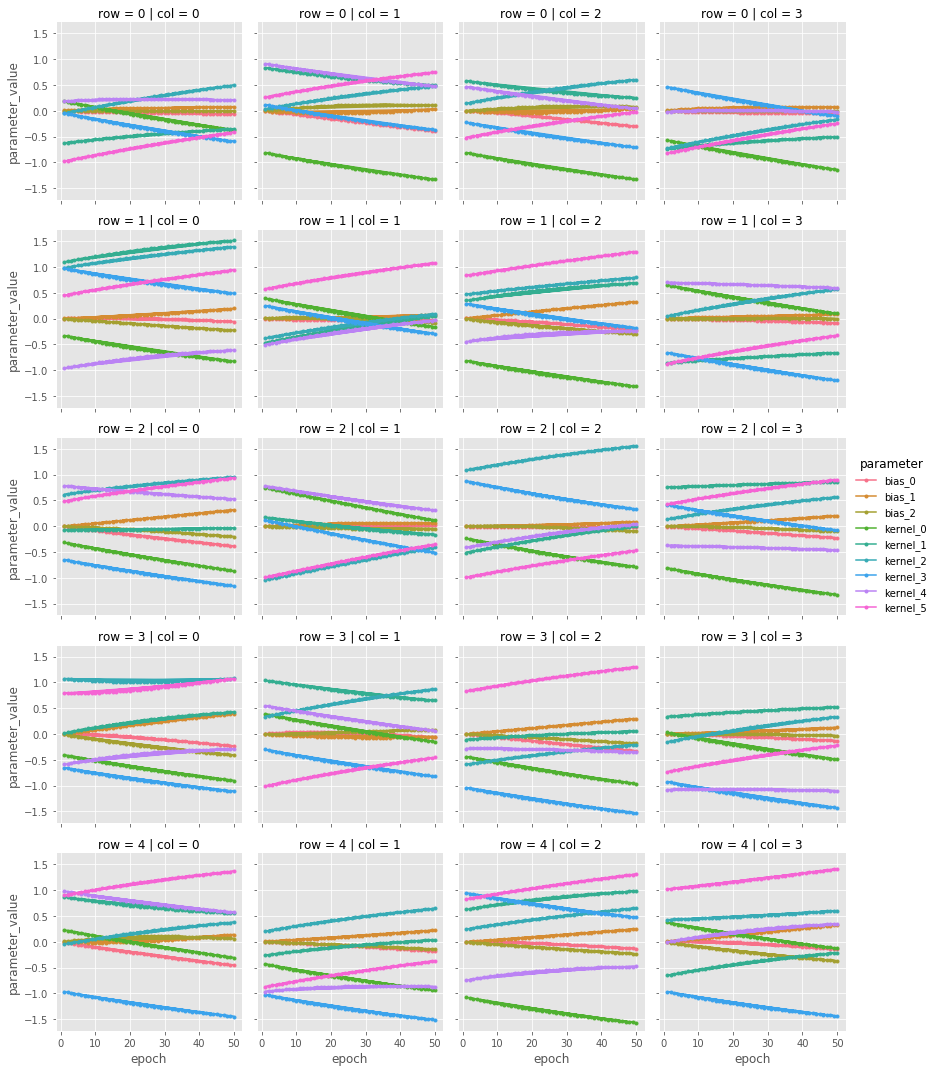

In [27]:
g=sns.FacetGrid(df_new,col='col',row='row',hue='parameter')
g=(g.map(plt.plot,'epoch','parameter_value',marker='.').add_legend())

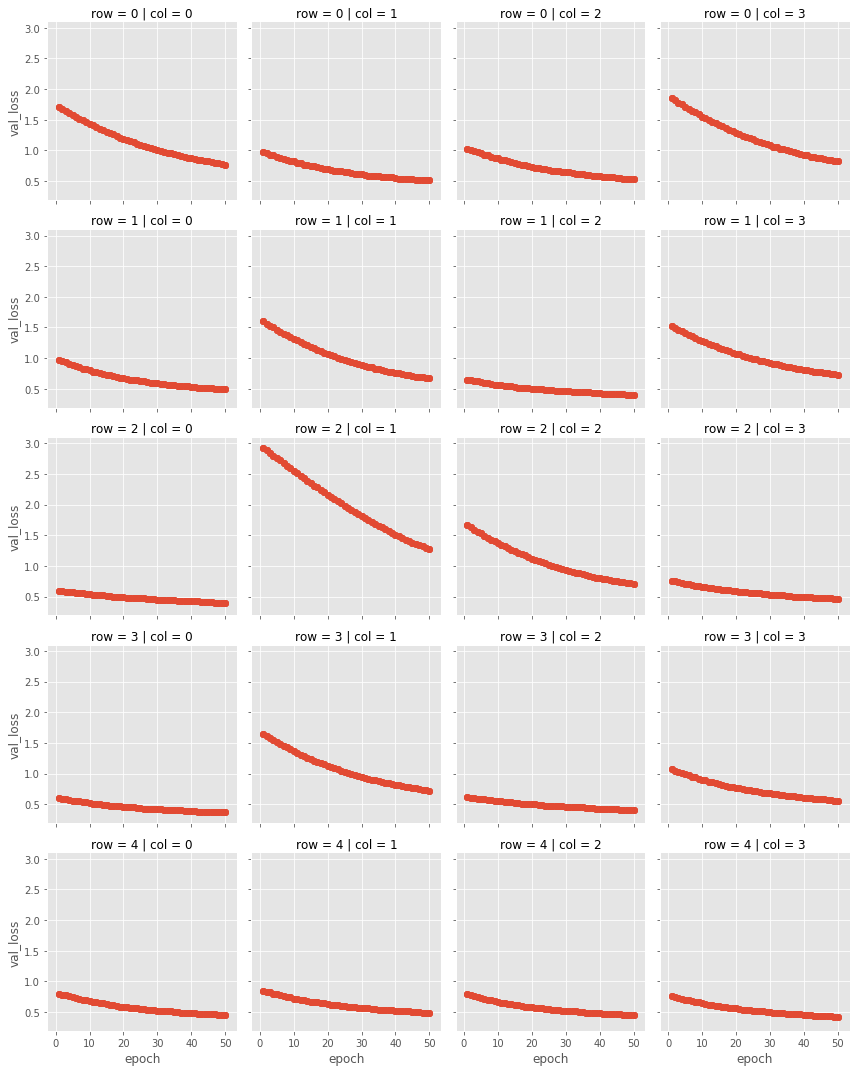

In [30]:
g=sns.FacetGrid(df_new,col='col',row='row')
g=g.map(plt.scatter,'epoch','val_loss')